# N electrons meet in a crystal

<center><img src="./images/qdef-banner.png" style="width: 500px">

The main goal of this notebook was to develop the classes `CrystalElectronsSCoupling` and `CrystalElectronsLLCoupling` to couple electrons in sequence and in like-to-like groups. Both of which were condensed in qdef.py.

The development code was left here and would be hard to interpret again.
</center>

In [1]:
%load_ext line_profiler
%load_ext autoreload
# provide cell timings
%load_ext autotime
%autoreload 2
import sympy as sp
import numpy as np
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False
from qdef import *
from misc import *
from IPython.display import display, Math, Latex, HTML
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
import time
from itertools import product
from itertools import permutations
from sympy import Eijk as εijk

Reloading /Users/juan/Zia Lab/Codebase/qdef/data/CPGs.pkl ...


In [4]:
CrystalElectronsSCoupling?

Init signature: CrystalElectronsSCoupling(group_label, Γs)
Docstring:      Couple electrons in sequence, adding one at a time.
Init docstring:
Parameters
----------
group_label (str): a string representing a point group
Γs     (iterable): with irrep symbols
File:           ~/Zia Lab/Codebase/qdef/qdef.py
Type:           type
Subclasses:     


In [5]:
CrystalElectronsLLCoupling?

Init signature: CrystalElectronsLLCoupling(group_label, Γ1s, Γ2s)
Docstring:      Couple two groups of electrons in one fell swoop.
Init docstring:
group_label (str): label for a crystallographic point group
Γ1s    (2-tuple): (irrep_symbol (sp.Symbol), num_electrons (int))
Γ2s    (2-tuple): (irrep_symbol (sp.Symbol), num_electrons (int))
File:           ~/Zia Lab/Codebase/qdef/qdef.py
Type:           type
Subclasses:     


As an example let's couple two T_2 electrons and two E electrons.

In [6]:
t2e2 = CrystalElectronsLLCoupling('O',[sp.Symbol('T_2'),2],[sp.Symbol('E'),2])

Here are the wavefunctions grouped in their corresponding terms. Only the first wavefunction being printed (if all are wanted make print_all True)

In [7]:
print_all = False
terms = {}
collected = {}
for k,v in t2e2.equiv_waves.items():
    if k.terms[-1] not in terms:
        terms[k.terms[-1]] = 0
        collected[k.terms[-1]] = []
    terms[k.terms[-1]] += 1
    collected[k.terms[-1]].append((k,v))

terms = OrderedDict()
econfig_maker = lambda x,y: sp.Symbol(sp.latex(x).lower()) * sp.Symbol(sp.latex(y).lower())
for wave_key, wave in t2e2.equiv_waves.items():
    this_term = wave_key.terms[-1]
    if this_term not in terms:
        terms[this_term] = []
    terms[this_term].append((wave_key,wave))
    # display(wave.as_ket())
sorted_terms = sorted(terms.keys(), key= lambda x: x[0])
for term in sorted_terms:
    terms[term] = list(sorted(terms[term], key=lambda x: str(x[0].γ)))
counter = 0
for term in sorted_terms:
    display(HTML('<hr>'))
    term_symb = sp.Symbol('{}^{%d}%s' % (term[0]*2+1, sp.latex(term[1])))
    display(term_symb)
    num_waves = len(terms[term])
    for wave_key, wave in terms[term]:
        e_config = sp.latex(reduce(sp.Mul,wave_key.electrons)).lower()
        multiplicity = int(wave_key.S*2+1)
        M = sp.latex(wave_key.M)
        γ = sp.latex(wave_key.γ)
        the_wave = sp.latex(as_det_ket(wave))
        wave_line = '\psi_{%d}(%s,%s,M=%s,%s) = %s' % (counter+1, e_config, term_symb, M, γ, the_wave)
        counter += 1
        display(Math(wave_line))
        if not print_all:
            if num_waves != 1:
                plurality = 's' if (num_waves-1)>1 else ''
                msg = '(... and %d other wave function%s ...)' % (num_waves-1, plurality)
                display(Math('\\textrm{%s}' % msg))
            break
else:
    display(HTML('<hr>'))

{}^{1}A_{1}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{1}E

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{1}A_{2}

<IPython.core.display.Math object>

{}^{1}T_{2}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{1}T_{1}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{3}A_{2}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{3}E

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{3}T_{1}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{3}T_{2}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{5}T_{2}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [18]:
econfig = CrystalElectronsLLCoupling('O',[sp.Symbol('T_2'),5],[sp.Symbol('E'),3])

In [19]:
print_all = True
terms = {}
collected = {}
for k,v in econfig.equiv_waves.items():
    if k.terms[-1] not in terms:
        terms[k.terms[-1]] = 0
        collected[k.terms[-1]] = []
    terms[k.terms[-1]] += 1
    collected[k.terms[-1]].append((k,v))

terms = OrderedDict()
econfig_maker = lambda x,y: sp.Symbol(sp.latex(x).lower()) * sp.Symbol(sp.latex(y).lower())
for wave_key, wave in econfig.equiv_waves.items():
    this_term = wave_key.terms[-1]
    if this_term not in terms:
        terms[this_term] = []
    terms[this_term].append((wave_key,wave))
    # display(wave.as_ket())
sorted_terms = sorted(terms.keys(), key= lambda x: x[0])
for term in sorted_terms:
    terms[term] = list(sorted(terms[term], key=lambda x: str(x[0].γ)))
counter = 0
for term in sorted_terms:
    display(HTML('<hr>'))
    term_symb = sp.Symbol('{}^{%d}%s' % (term[0]*2+1, sp.latex(term[1])))
    display(term_symb)
    num_waves = len(terms[term])
    for wave_key, wave in terms[term]:
        e_config = sp.latex(reduce(sp.Mul,wave_key.electrons)).lower()
        multiplicity = int(wave_key.S*2+1)
        M = sp.latex(wave_key.M)
        γ = sp.latex(wave_key.γ)
        the_wave = sp.latex(as_det_ket(wave))
        wave_line = '\psi_{%d}(%s,%s,M=%s,%s) = %s' % (counter+1, e_config, term_symb, M, γ, the_wave)
        counter += 1
        display(Math(wave_line))
        if not print_all:
            if num_waves != 1:
                plurality = 's' if (num_waves-1)>1 else ''
                msg = '(... and %d other wave function%s ...)' % (num_waves-1, plurality)
                display(Math('\\textrm{%s}' % msg))
            break
else:
    display(HTML('<hr>'))

{}^{1}T_{2}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{1}T_{1}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{3}T_{2}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{3}T_{1}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Like-to-like Coupling "LL coupling"

In [333]:
from collections import namedtuple
from functools import reduce
Ψ = namedtuple('Ψ',['electrons','terms','γ','S','M']) 

In [423]:
class CrystalElectronsSCoupling():
    '''
    Couple electrons in sequence.
    '''
    remember_remember = {}
    def __init__(self, group_label, Γs):
        self.Γs = Γs
        self.group_label = group_label
        self.group = CPGs.get_group_by_label(self.group_label)
        self.group_CGs = self.group.CG_coefficients
        self.flat_labels = dict(sum([list(l.items()) for l in list(new_labels[self.group_label].values())],[]))
        self.group_CGs = {(self.flat_labels[k[0]], self.flat_labels[k[1]], self.flat_labels[k[2]]):v for k,v in self.group_CGs.items()}
        self.irreps = self.group.irrep_labels
        self.ms = [-sp.S(1)/2,sp.S(1)/2]
        self.s_half = sp.S(1)/2
        self.component_labels = {k:list(v.values()) for k,v in new_labels[self.group_label].items()}
        self.inequiv_waves = self.elec_aggregate(self.Γs)
        if len(self.Γs) == 1:
            self.equiv_waves = self.inequiv_waves
        else:
            self.equiv_waves = self.to_equiv_electrons()

    def qet_divide(self, qet0, qet1):
        '''
        Given   two   qets,   assumed   to   be   superpositions  of
        determinantal states. Determine if they are collinear and if
        they are, provide their ratio.

        Parameters
        ----------
        qet0    (qdef.Qet) : a qet with determinantal keys.
        qet1    (qdef.Qet) : a qet with determinantal keys.

        Returns
        -------
        ratio (num): 0 if qets are not collinear, otherwise equal to
        qet0/qet1.


        '''
        if len(qet0.dict) != len(qet1.dict):
            return 0
        set0 = frozenset(map(frozenset,qet0.dict.keys()))
        set1 = frozenset(map(frozenset,qet1.dict.keys()))
        num_parts = len(qet0.dict)
        # a necessary condition for them to be possibly collinear
        # is that they should have have the same sets of quantum
        # numbers.
        if set0 != set1:
            return 0
        else:
            ratios = []
            # iterate over the quantum nums of the first qet
            for qet_key_0, qet_val_0 in qet0.dict.items():
                set0 = set(qet_key_0)
                # and determine the ratio that it has
                # to all of the parts of the other qet
                # allowing for reaarangmenets valid
                # under determinantal state rules
                for qet_key_1, qet_val_1 in qet1.dict.items():
                    set1 = set(qet_key_1)
                    if set0 == set1:
                        ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                        sign = εijk(*ordering)
                        ratios.append(sign * qet_val_0/qet_val_1)
                        continue
        if ratios == []:
            return 0
        else:
            # if all of the ratios are equal
            # then the ratio of the two qets
            # is well defined
            if len(set(ratios)) == 1 and len(ratios) == num_parts:
                return ratios[0]
            else:
                return 0

    def det_qet_simplify(self, qet):
        equivalent_parts = {}
        standard_order = {} # this holds the standard order to which all the other list members will be referred to
        for ket_part_key, ket_part_coeff in qet.dict.items():
            set_ket = frozenset(ket_part_key)
            if set_ket not in equivalent_parts:
                equivalent_parts[set_ket] = []
                standard_order[set_ket] = ket_part_key
            equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
        # once I've grouped them together into pices of equivalent parts
        # i then need to rearrange and properly sign the rearrangements
        det_simple = []
        for equivalent_key in equivalent_parts:
            base_order = standard_order[equivalent_key]
            total_coeff = 0
            equiv_parts = equivalent_parts[equivalent_key]
            for equiv_part in equiv_parts:
                ordering = [base_order.index(part) for part in equiv_part[0]]
                sign = εijk(*ordering)
                total_coeff += sign*equiv_part[1]
            final = (base_order, total_coeff)
            if total_coeff != 0:
                det_simple.append(final)
        return det_simple

    def adder(self, ψ_12s, Γ3):
        '''
        This function gets a dictionary of wave functions
        and an additional electron that needs to be added
        to them.
        '''
        #>2 this is called with Γ3
        ψ_123s = {}
        comps_3 = self.component_labels[Γ3]
        s3 = sp.S(1)/2

        for ψ_12, qet_12 in ψ_12s.items():
            electrons = ψ_12.electrons
            terms = ψ_12.terms
            Γ12 = terms[-1][1]
            γ12 = ψ_12.γ
            S12, M12 = ψ_12.S, ψ_12.M
            S123s = lrange(S12, s3)
            Γ123s = self.group.product_table.odict[(Γ12, Γ3)] # these are the possible Γs from Γ12XΓ3
            for Γ123, S123 in product(Γ123s, S123s):
                M123s = mrange(S123)
                γ123s = self.component_labels[Γ123]
                for γ123, m3, γ3, M123 in product(γ123s, self.ms, comps_3, M123s):
                    sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
                    # coupling a γ12, γ3 to get a final γ
                    gCG2 = self.group_CGs.setdefault((γ12, γ3, γ123), 0)
                    coeff = sCG2 * gCG2
                    if coeff == 0:
                        continue
                    ψ_123 = Ψ(electrons = electrons + (Γ3,),
                                terms = terms + ((S123,Γ123),),
                                    γ = γ123,
                                    S = S123,
                                    M = M123
                            )
                    if ψ_123 not in ψ_123s:
                        ψ_123s[ψ_123] = Qet({})
                    γ3f = (γ3 if (m3 > 0) else bar_symbol(γ3))
                    ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))
        return ψ_123s

    def elec_aggregate(self, Γs):
        if len(Γs) == 0:
            return {}
        elif len(Γs) == 1:
            Γ1 = Γs[0]
            S = self.s_half
            ms = mrange(S)
            comps_1 = self.component_labels[Γ1]
            ψs = {}
            for m, γ in product(ms, comps_1):
                ψ = Ψ(electrons = (Γ1,),
                        terms = ((S,Γ1),),
                        γ = γ,
                        S = S,
                        M = m
                        )
                γf = (γ if (m > 0) else bar_symbol(γ))
                total_ket_part_key = (γf,)
                if ψ not in ψs:
                    ψs[ψ] = {}
                if total_ket_part_key not in ψs[ψ]:
                    ψs[ψ][total_ket_part_key] = 0
                ψs[ψ][total_ket_part_key] = 1
            ψs = {k : Qet(v) for k,v in ψs.items()} 
            return ψs
        elif len(Γs) == 2:
            s1, s2 = self.s_half, self.s_half
            Γ1, Γ2 = Γs
            comps_1, comps_2 = [self.component_labels[ir] for ir in [Γ1, Γ2]]
            Γ12s = self.group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
            S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
            ψ_12s = {}

            for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, self.ms, self.ms, Γ12s, S12s):
                comps_12 = self.component_labels[Γ12]
                M12s = mrange(S12)
                for γ12, M12 in product(comps_12, M12s):
                    ψ = Ψ(electrons = (Γ1, Γ2),
                        terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
                        γ = γ12,
                        S = S12,
                        M = M12
                        )
                    # summing s1 and s2 to yield S12
                    sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                    # coupling a γ1, γ2 to get a γ12
                    gCG1 = self.group_CGs.setdefault((γ1, γ2, γ12), 0)
                    coeff = sCG1 * gCG1
                    if coeff == 0:
                        continue
                    # collect in the dictionary all the parts that correspond to the sums
                    if ψ not in ψ_12s:
                        ψ_12s[ψ] = {}
                    γ1f = (γ1 if (m1 > 0) else bar_symbol(γ1))
                    γ2f = (γ2 if (m2 > 0) else bar_symbol(γ2))
                    total_ket_part_key = (γ1f, γ2f)
                    if total_ket_part_key not in ψ_12s[ψ]:
                        ψ_12s[ψ][total_ket_part_key] = 0
                    ψ_12s[ψ][total_ket_part_key] += coeff
            ψ_12s = {k : Qet(v) for k,v in ψ_12s.items()} 
            # print("returning %d qets" % len(ψ_12s))
            return ψ_12s
        else:
            Γ_train, Γ_last = Γs[:-1], Γs[-1]
            # decimate until only two electrons are added
            ψ_totals = self.adder(
                            self.elec_aggregate(Γ_train),
                            Γ_last
                                 )
            # print("returning %d qets" % len(ψ_totals))
            return ψ_totals
        
    def to_equiv_electrons(self):
        # To account for electrons being equivalent it suffices to interpret each
        # tuple of symbols under the keys of each qet to be a slater determinant
        # in turn this allows simplifying the qets to account for the symmetries
        # under exchange of symbols/electrons inside the keys

        ψ_totals = self.inequiv_waves
        # print("Calculating equivalent electron determinantal states ...")
        # print("Starting from %d qets ..." % len(ψ_totals))
        simplified_kets = {}
        for ψ_123, qet_123 in ψ_totals.items():
            qet_simplified = self.det_qet_simplify(qet_123)
            if len(qet_simplified) != 0:
                    simplified_kets[ψ_123] = Qet(dict(qet_simplified))
                    the_normalizer = 1/simplified_kets[ψ_123].norm()
                    simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

        # The same qet might have been arrived at by different paths, the only
        # difference begin an overall phase.
        # This last step only keeps the qets that are non-equivalent.

        full_det_qets = []
        qsymbs = []
        for total_ket_key_0, simple_ket_0 in simplified_kets.items():
            ratios = []
            for simple_ket_1 in full_det_qets:
                divvy = self.qet_divide(simple_ket_0, simple_ket_1)
                ratios.append(divvy==0)
            ratios = sum(ratios)
            if ratios == len(full_det_qets):
                full_det_qets.append(simple_ket_0)
                qsymbs.append(total_ket_key_0)
        full_det_qets = dict(zip(qsymbs, full_det_qets))
        # print("Ending with %d qets ..." % len(full_det_qets))
        return full_det_qets

In [440]:
class CrystalElectronsLLcoupling():
    '''
    Couple two groups of electrons.
    '''
    def __init__(self, group_label, Γ1s, Γ2s):
        '''
        group_label (str): label for a crystallographic point group
        Γ1s    (2-tuple): (irrep_symbol (sp.Symbol), num_electrons (int))
        Γ2s    (2-tuple): (irrep_symbol (sp.Symbol), num_electrons (int))
        '''
        if len(Γ1s) == 0:
            self.Γ1s = []
        else:
            self.Γ1s = [Γ1s[0] for _ in range(Γ1s[1])]
        if len(Γ2s) == 0:
            self.Γ2s = []
        else:
            self.Γ2s = [Γ2s[0] for _ in range(Γ2s[1])]
        self.crystalelectron0 = CrystalElectronsSCoupling(group_label, self.Γ1s)
        self.crystalelectron1 = CrystalElectronsSCoupling(group_label, self.Γ2s)
        self.group_label = group_label
        self.group = CPGs.get_group_by_label(self.group_label)
        self.group_CGs = self.group.CG_coefficients
        self.flat_labels = dict(sum([list(l.items()) for l in list(new_labels[self.group_label].values())],[]))
        self.group_CGs = {(self.flat_labels[k[0]], self.flat_labels[k[1]], self.flat_labels[k[2]]):v for k,v in self.group_CGs.items()}
        self.irreps = self.group.irrep_labels
        self.ms = [-sp.S(1)/2,sp.S(1)/2]
        self.s_half = sp.S(1)/2
        self.component_labels = {k:list(v.values()) for k,v in new_labels[self.group_label].items()}
        self.equiv_waves = self.wave_muxer(self.crystalelectron0.equiv_waves,
                                     self.crystalelectron1.equiv_waves)
        self.equiv_waves = self.to_equiv_electrons(self.equiv_waves)

    def wave_muxer(self, ψ_12s, ψ_34s):
        '''
        Takes two dictionaries of wavefunctions and couples them.
        '''
        if len(ψ_34s)== 0:
            return ψ_12s
        if len(ψ_12s) == 0:
            return ψ_34s
        ψ_1234s = {}
        for ψ_12, qet_12 in ψ_12s.items():
            electrons12 = ψ_12.electrons
            terms12 = ψ_12.terms
            Γ12 = terms12[-1][1]
            γ12 = ψ_12.γ
            S12, M12 = ψ_12.S, ψ_12.M
            for ψ_34, qet_34 in ψ_34s.items():
                electrons34 = ψ_34.electrons
                terms34 = ψ_34.terms
                Γ34 = terms34[-1][1]
                γ34 = ψ_34.γ
                S34, M34 = ψ_34.S, ψ_34.M
                S1234s = lrange(S12, S34)
                Γ1234s = self.group.product_table.odict[(Γ12, Γ34)]
                for Γ1234, S1234 in product(Γ1234s, S1234s):
                    M1234s = mrange(S1234)
                    γ1234s = component_labels[Γ1234]
                    for γ1234, M1234 in product(γ1234s, M1234s):
                        sCG2 = clebschG.eva(S12, S34, S1234, M12, M34, M1234)
                        # coupling a γ12, γ3 to get a final γ
                        gCG2 = self.group_CGs.setdefault((γ12, γ34, γ1234), 0)
                        coeff = sCG2 * gCG2
                        if coeff == 0:
                            continue
                        ψ_1234 = Ψ(electrons = electrons12 + electrons34,
                                    terms = (terms12[-1], terms34[-1],(S1234, Γ1234)),
                                        γ = γ1234,
                                        S = S1234,
                                        M = M1234
                                )
                        if ψ_1234 not in ψ_1234s:
                            ψ_1234s[ψ_1234] = Qet({})
                        # γ3f = (γ3 if (m3 > 0) else bar_symbol(γ3))
                        ψ_1234s[ψ_1234] = ψ_1234s[ψ_1234] + coeff* (qet_12 * qet_34)
        return ψ_1234s

    def qet_divide(self, qet0, qet1):
        '''
        Given   two   qets,   assumed   to   be   superpositions  of
        determinantal states. Determine if they are collinear and if
        they are, provide their ratio.

        Parameters
        ----------
        qet0    (qdef.Qet) : a qet with determinantal keys.
        qet1    (qdef.Qet) : a qet with determinantal keys.

        Returns
        -------
        ratio (num): 0 if qets are not collinear, otherwise equal to
        qet0/qet1.


        '''
        if len(qet0.dict) != len(qet1.dict):
            return 0
        set0 = frozenset(map(frozenset,qet0.dict.keys()))
        set1 = frozenset(map(frozenset,qet1.dict.keys()))
        num_parts = len(qet0.dict)
        # a necessary condition for them to be possibly collinear
        # is that they should have have the same sets of quantum
        # numbers.
        if set0 != set1:
            return 0
        else:
            ratios = []
            # iterate over the quantum nums of the first qet
            for qet_key_0, qet_val_0 in qet0.dict.items():
                set0 = set(qet_key_0)
                # and determine the ratio that it has
                # to all of the parts of the other qet
                # allowing for reaarangmenets valid
                # under determinantal state rules
                for qet_key_1, qet_val_1 in qet1.dict.items():
                    set1 = set(qet_key_1)
                    if set0 == set1:
                        ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                        sign = εijk(*ordering)
                        ratios.append(sign * qet_val_0/qet_val_1)
                        continue
        if ratios == []:
            return 0
        else:
            # if all of the ratios are equal
            # then the ratio of the two qets
            # is well defined
            if len(set(ratios)) == 1 and len(ratios) == num_parts:
                return ratios[0]
            else:
                return 0

    def det_qet_simplify(self, qet):
        equivalent_parts = {}
        standard_order = {} # this holds the standard order to which all the other list members will be referred to
        for ket_part_key, ket_part_coeff in qet.dict.items():
            set_ket = frozenset(ket_part_key)
            if set_ket not in equivalent_parts:
                equivalent_parts[set_ket] = []
                standard_order[set_ket] = ket_part_key
            equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
        # once I've grouped them together into pices of equivalent parts
        # i then need to rearrange and properly sign the rearrangements
        det_simple = []
        for equivalent_key in equivalent_parts:
            base_order = standard_order[equivalent_key]
            total_coeff = 0
            equiv_parts = equivalent_parts[equivalent_key]
            for equiv_part in equiv_parts:
                ordering = [base_order.index(part) for part in equiv_part[0]]
                sign = εijk(*ordering)
                total_coeff += sign*equiv_part[1]
            final = (base_order, total_coeff)
            if total_coeff != 0:
                det_simple.append(final)
        return det_simple

    def to_equiv_electrons(self, waves):
        # To account for electrons being equivalent it suffices to interpret each
        # tuple of symbols under the keys of each qet to be a slater determinant
        # in turn this allows simplifying the qets to account for the symmetries
        # under exchange of symbols/electrons inside the keys

        ψ_totals = waves
        # print("Calculating equivalent electron determinantal states ...")
        # print("Starting from %d qets ..." % len(ψ_totals))
        simplified_kets = {}
        for ψ_123, qet_123 in ψ_totals.items():
            qet_simplified = self.det_qet_simplify(qet_123)
            if len(qet_simplified) != 0:
                    simplified_kets[ψ_123] = Qet(dict(qet_simplified))
                    the_normalizer = 1/simplified_kets[ψ_123].norm()
                    simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

        # The same qet might have been arrived at by different paths, the only
        # difference begin an overall phase.
        # This last step only keeps the qets that are non-equivalent.

        full_det_qets = []
        qsymbs = []
        for total_ket_key_0, simple_ket_0 in simplified_kets.items():
            ratios = []
            for simple_ket_1 in full_det_qets:
                divvy = self.qet_divide(simple_ket_0, simple_ket_1)
                ratios.append(divvy==0)
            ratios = sum(ratios)
            if ratios == len(full_det_qets):
                full_det_qets.append(simple_ket_0)
                qsymbs.append(total_ket_key_0)
        full_det_qets = dict(zip(qsymbs, full_det_qets))
        return full_det_qets

In [448]:
multi_wave_functions = CrystalElectronsLLcoupling('O',[sp.Symbol('E'),3], [sp.Symbol('T_1'),2])

# Coupling more than a single electron to a set of wavefunctions

In [327]:
from collections import namedtuple
from functools import reduce
Ψ = namedtuple('Ψ',['electrons','terms','γ','S','M']) 

In [328]:
class CrystalElectrons():
    '''
    A calculator as you've never seen before.
    '''
    remember_remember = {}
    def __init__(self, group_label, Γs):
        self.Γs = Γs
        self.group_label = group_label
        self.group = CPGs.get_group_by_label(self.group_label)
        self.group_CGs = self.group.CG_coefficients
        self.flat_labels = dict(sum([list(l.items()) for l in list(new_labels[self.group_label].values())],[]))
        self.group_CGs = {(self.flat_labels[k[0]], self.flat_labels[k[1]], self.flat_labels[k[2]]):v for k,v in self.group_CGs.items()}
        self.irreps = self.group.irrep_labels
        self.ms = [-sp.S(1)/2,sp.S(1)/2]
        self.s_half = sp.S(1)/2
        self.component_labels = {k:list(v.values()) for k,v in new_labels[self.group_label].items()}
        print("Calculating inequivalent electon wave functions ...")
        self.inequiv_waves = self.elec_aggregate(self.Γs)
        self.equiv_waves = self.to_equiv_electrons()

    def qet_divide(self, qet0, qet1):
        '''
        Given   two   qets,   assumed   to   be   superpositions  of
        determinantal states. Determine if they are collinear and if
        they are, provide their ratio.

        Parameters
        ----------
        qet0    (qdef.Qet) : a qet with determinantal keys.
        qet1    (qdef.Qet) : a qet with determinantal keys.

        Returns
        -------
        ratio (num): 0 if qets are not collinear, otherwise equal to
        qet0/qet1.


        '''
        if len(qet0.dict) != len(qet1.dict):
            return 0
        set0 = frozenset(map(frozenset,qet0.dict.keys()))
        set1 = frozenset(map(frozenset,qet1.dict.keys()))
        num_parts = len(qet0.dict)
        # a necessary condition for them to be possibly collinear
        # is that they should have have the same sets of quantum
        # numbers.
        if set0 != set1:
            return 0
        else:
            ratios = []
            # iterate over the quantum nums of the first qet
            for qet_key_0, qet_val_0 in qet0.dict.items():
                set0 = set(qet_key_0)
                # and determine the ratio that it has
                # to all of the parts of the other qet
                # allowing for reaarangmenets valid
                # under determinantal state rules
                for qet_key_1, qet_val_1 in qet1.dict.items():
                    set1 = set(qet_key_1)
                    if set0 == set1:
                        ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                        sign = εijk(*ordering)
                        ratios.append(sign * qet_val_0/qet_val_1)
                        continue
        if ratios == []:
            return 0
        else:
            # if all of the ratios are equal
            # then the ratio of the two qets
            # is well defined
            if len(set(ratios)) == 1 and len(ratios) == num_parts:
                return ratios[0]
            else:
                return 0

    def det_qet_simplify(self, qet):
        equivalent_parts = {}
        standard_order = {} # this holds the standard order to which all the other list members will be referred to
        for ket_part_key, ket_part_coeff in qet.dict.items():
            set_ket = frozenset(ket_part_key)
            if set_ket not in equivalent_parts:
                equivalent_parts[set_ket] = []
                standard_order[set_ket] = ket_part_key
            equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
        # once I've grouped them together into pices of equivalent parts
        # i then need to rearrange and properly sign the rearrangements
        det_simple = []
        for equivalent_key in equivalent_parts:
            base_order = standard_order[equivalent_key]
            total_coeff = 0
            equiv_parts = equivalent_parts[equivalent_key]
            for equiv_part in equiv_parts:
                ordering = [base_order.index(part) for part in equiv_part[0]]
                sign = εijk(*ordering)
                total_coeff += sign*equiv_part[1]
            final = (base_order, total_coeff)
            if total_coeff != 0:
                det_simple.append(final)
        return det_simple

    def adder(self, ψ_12s, Γ3):
        '''
        This function gets a dictionary of wave functions
        and an additional electron that needs to be added
        to them.
        '''
        #>2 this is called with Γ3
        ψ_123s = {}
        comps_3 = self.component_labels[Γ3]
        s3 = sp.S(1)/2

        for ψ_12, qet_12 in ψ_12s.items():
            electrons = ψ_12.electrons
            terms = ψ_12.terms
            Γ12 = terms[-1][1]
            γ12 = ψ_12.γ
            S12, M12 = ψ_12.S, ψ_12.M
            S123s = lrange(S12, s3)
            Γ123s = self.group.product_table.odict[(Γ12, Γ3)] # these are the possible Γs from Γ12XΓ3
            for Γ123, S123 in product(Γ123s, S123s):
                M123s = mrange(S123)
                γ123s = self.component_labels[Γ123]
                for γ123, m3, γ3, M123 in product(γ123s, self.ms, comps_3, M123s):
                    sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
                    # coupling a γ12, γ3 to get a final γ
                    gCG2 = self.group_CGs.setdefault((γ12, γ3, γ123), 0)
                    coeff = sCG2 * gCG2
                    if coeff == 0:
                        continue
                    ψ_123 = Ψ(electrons = electrons + (Γ3,),
                                terms = terms + ((S123,Γ123),),
                                    γ = γ123,
                                    S = S123,
                                    M = M123
                            )
                    if ψ_123 not in ψ_123s:
                        ψ_123s[ψ_123] = Qet({})
                    γ3f = (γ3 if (m3 > 0) else bar_symbol(γ3))
                    ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))
        return ψ_123s

    def elec_aggregate(self, Γs):
        print("Adding", Γs)
        if len(Γs) == 2:
            # print("Two singles are easy ...")
            s1, s2 = self.s_half, self.s_half
            Γ1, Γ2 = Γs
            comps_1, comps_2 = [self.component_labels[ir] for ir in [Γ1, Γ2]]
            Γ12s = self.group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
            S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
            ψ_12s = {}

            for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, self.ms, self.ms, Γ12s, S12s):
                comps_12 = self.component_labels[Γ12]
                M12s = mrange(S12)
                for γ12, M12 in product(comps_12, M12s):
                    ψ = Ψ(electrons = (Γ1, Γ2),
                        terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
                        γ = γ12,
                        S = S12,
                        M = M12
                        )
                    # summing s1 and s2 to yield S12
                    sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                    # coupling a γ1, γ2 to get a γ12
                    gCG1 = self.group_CGs.setdefault((γ1, γ2, γ12), 0)
                    coeff = sCG1 * gCG1
                    if coeff == 0:
                        continue
                    # collect in the dictionary all the parts that correspond to the sums
                    if ψ not in ψ_12s:
                        ψ_12s[ψ] = {}
                    γ1f = (γ1 if (m1 > 0) else bar_symbol(γ1))
                    γ2f = (γ2 if (m2 > 0) else bar_symbol(γ2))
                    total_ket_part_key = (γ1f, γ2f)
                    if total_ket_part_key not in ψ_12s[ψ]:
                        ψ_12s[ψ][total_ket_part_key] = 0
                    ψ_12s[ψ][total_ket_part_key] += coeff
            ψ_12s = {k : Qet(v) for k,v in ψ_12s.items()} 
            # print("returning %d qets" % len(ψ_12s))
            return ψ_12s
        else:
            Γ_train, Γ_last = Γs[:-1], Γs[-1]
            # decimate until only two electrons are added
            ψ_totals = self.adder(
                            self.elec_aggregate(Γ_train),
                            Γ_last
                                 )
            # print("returning %d qets" % len(ψ_totals))
            return ψ_totals
        
    def to_equiv_electrons(self):
        # To account for electrons being equivalent it suffices to interpret each
        # tuple of symbols under the keys of each qet to be a slater determinant
        # in turn this allows simplifying the qets to account for the symmetries
        # under exchange of symbols/electrons inside the keys

        ψ_totals = self.inequiv_waves
        print("Calculating equivalent electron determinantal states ...")
        # print("Starting from %d qets ..." % len(ψ_totals))
        simplified_kets = {}
        for ψ_123, qet_123 in ψ_totals.items():
            qet_simplified = self.det_qet_simplify(qet_123)
            if len(qet_simplified) != 0:
                    simplified_kets[ψ_123] = Qet(dict(qet_simplified))
                    the_normalizer = 1/simplified_kets[ψ_123].norm()
                    simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

        # The same qet might have been arrived at by different paths, the only
        # difference begin an overall phase.
        # This last step only keeps the qets that are non-equivalent.

        full_det_qets = []
        qsymbs = []
        for total_ket_key_0, simple_ket_0 in simplified_kets.items():
            ratios = []
            for simple_ket_1 in full_det_qets:
                divvy = self.qet_divide(simple_ket_0, simple_ket_1)
                ratios.append(divvy==0)
            ratios = sum(ratios)
            if ratios == len(full_det_qets):
                full_det_qets.append(simple_ket_0)
                qsymbs.append(total_ket_key_0)
        full_det_qets = dict(zip(qsymbs, full_det_qets))
        # print("Ending with %d qets ..." % len(full_det_qets))
        return full_det_qets

In [329]:
t2t2 = CrystalElectrons('O',[sp.Symbol('T_2')]*2)
ee = CrystalElectrons('O',[sp.Symbol('E')]*2)
group_label = 'O'
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}
irreps = group.irrep_labels
component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}

Calculating inequivalent electon wave functions ...
Adding [T_2, T_2]
Calculating equivalent electron determinantal states ...
Calculating inequivalent electon wave functions ...
Adding [E, E]
Calculating equivalent electron determinantal states ...


In [330]:
def wave_muxer(ψ_12s, ψ_34s):
    '''
    Takes two dictionaries of wavefunctions and couples them.
    '''
    ψ_1234s = {}
    for ψ_12, qet_12 in ψ_12s.items():
        electrons12 = ψ_12.electrons
        terms12 = ψ_12.terms
        Γ12 = terms12[-1][1]
        γ12 = ψ_12.γ
        S12, M12 = ψ_12.S, ψ_12.M
        for ψ_34, qet_34 in ψ_34s.items():
            electrons34 = ψ_34.electrons
            terms34 = ψ_34.terms
            Γ34 = terms34[-1][1]
            γ34 = ψ_34.γ
            S34, M34 = ψ_34.S, ψ_34.M
            S1234s = lrange(S12, S34)
            Γ1234s = group.product_table.odict[(Γ12, Γ34)]
            for Γ1234, S1234 in product(Γ1234s, S1234s):
                M1234s = mrange(S1234)
                γ1234s = component_labels[Γ1234]
                for γ1234, M1234 in product(γ1234s, M1234s):
                    sCG2 = clebschG.eva(S12, S34, S1234, M12, M34, M1234)
                    # coupling a γ12, γ3 to get a final γ
                    gCG2 = group_CGs.setdefault((γ12, γ34, γ1234), 0)
                    coeff = sCG2 * gCG2
                    if coeff == 0:
                        continue
                    ψ_1234 = Ψ(electrons = electrons12 + electrons34,
                                terms = (terms12[-1], terms34[-1],(S1234, Γ1234)),
                                    γ = γ1234,
                                    S = S1234,
                                    M = M1234
                            )
                    if ψ_1234 not in ψ_1234s:
                        ψ_1234s[ψ_1234] = Qet({})
                    # γ3f = (γ3 if (m3 > 0) else bar_symbol(γ3))
                    ψ_1234s[ψ_1234] = ψ_1234s[ψ_1234] + coeff* (qet_12 * qet_34)
    return ψ_1234s
ψ_12s = ee.equiv_waves
ψ_34s = t2t2.equiv_waves
eet2t2 = wave_muxer(ψ_12s, ψ_34s)

# Doing sequential coupling by recursion

In [3]:
from collections import namedtuple
from functools import reduce

In [296]:
Ψ = namedtuple('Ψ',['electrons','terms','γ','S','M']) 

class CrystalElectrons():
    '''
    A calculator as you've never seen before.
    '''
    remember_remember = {}
    def __init__(self, group_label, Γs):
        self.Γs = Γs
        self.group_label = group_label
        self.group = CPGs.get_group_by_label(self.group_label)
        self.group_CGs = self.group.CG_coefficients
        self.flat_labels = dict(sum([list(l.items()) for l in list(new_labels[self.group_label].values())],[]))
        self.group_CGs = {(self.flat_labels[k[0]], self.flat_labels[k[1]], self.flat_labels[k[2]]):v for k,v in self.group_CGs.items()}
        self.irreps = self.group.irrep_labels
        self.ms = [-sp.S(1)/2,sp.S(1)/2]
        self.s_half = sp.S(1)/2
        self.component_labels = {k:list(v.values()) for k,v in new_labels[self.group_label].items()}
        print("Calculating inequivalent electon wave functions ...")
        self.inequiv_waves = self.elec_aggregate(self.Γs)
        self.equiv_waves = self.to_equiv_electrons()

    def qet_divide(self, qet0, qet1):
        '''
        Given   two   qets,   assumed   to   be   superpositions  of
        determinantal states. Determine if they are collinear and if
        they are, provide their ratio.

        Parameters
        ----------
        qet0    (qdef.Qet) : a qet with determinantal keys.
        qet1    (qdef.Qet) : a qet with determinantal keys.

        Returns
        -------
        ratio (num): 0 if qets are not collinear, otherwise equal to
        qet0/qet1.


        '''
        if len(qet0.dict) != len(qet1.dict):
            return 0
        set0 = frozenset(map(frozenset,qet0.dict.keys()))
        set1 = frozenset(map(frozenset,qet1.dict.keys()))
        num_parts = len(qet0.dict)
        # a necessary condition for them to be possibly collinear
        # is that they should have have the same sets of quantum
        # numbers.
        if set0 != set1:
            return 0
        else:
            ratios = []
            # iterate over the quantum nums of the first qet
            for qet_key_0, qet_val_0 in qet0.dict.items():
                set0 = set(qet_key_0)
                # and determine the ratio that it has
                # to all of the parts of the other qet
                # allowing for reaarangmenets valid
                # under determinantal state rules
                for qet_key_1, qet_val_1 in qet1.dict.items():
                    set1 = set(qet_key_1)
                    if set0 == set1:
                        ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                        sign = εijk(*ordering)
                        ratios.append(sign * qet_val_0/qet_val_1)
                        continue
        if ratios == []:
            return 0
        else:
            # if all of the ratios are equal
            # then the ratio of the two qets
            # is well defined
            if len(set(ratios)) == 1 and len(ratios) == num_parts:
                return ratios[0]
            else:
                return 0

    def det_qet_simplify(self, qet):
        equivalent_parts = {}
        standard_order = {} # this holds the standard order to which all the other list members will be referred to
        for ket_part_key, ket_part_coeff in qet.dict.items():
            set_ket = frozenset(ket_part_key)
            if set_ket not in equivalent_parts:
                equivalent_parts[set_ket] = []
                standard_order[set_ket] = ket_part_key
            equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
        # once I've grouped them together into pices of equivalent parts
        # i then need to rearrange and properly sign the rearrangements
        det_simple = []
        for equivalent_key in equivalent_parts:
            base_order = standard_order[equivalent_key]
            total_coeff = 0
            equiv_parts = equivalent_parts[equivalent_key]
            for equiv_part in equiv_parts:
                ordering = [base_order.index(part) for part in equiv_part[0]]
                sign = εijk(*ordering)
                total_coeff += sign*equiv_part[1]
            final = (base_order, total_coeff)
            if total_coeff != 0:
                det_simple.append(final)
        return det_simple

    def adder(self, ψ_12s, Γ3):
        '''
        This function gets a dictionary of wave functions
        and an additional electron that needs to be added
        to them.
        '''
        #>2 this is called with Γ3
        ψ_123s = {}
        comps_3 = self.component_labels[Γ3]
        s3 = sp.S(1)/2

        for ψ_12, qet_12 in ψ_12s.items():
            electrons = ψ_12.electrons
            terms = ψ_12.terms
            Γ12 = terms[-1][1]
            γ12 = ψ_12.γ
            S12, M12 = ψ_12.S, ψ_12.M
            S123s = lrange(S12, s3)
            Γ123s = self.group.product_table.odict[(Γ12, Γ3)] # these are the possible Γs from Γ12XΓ3
            for Γ123, S123 in product(Γ123s, S123s):
                M123s = mrange(S123)
                γ123s = self.component_labels[Γ123]
                for γ123, m3, γ3, M123 in product(γ123s, self.ms, comps_3, M123s):
                    sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
                    # coupling a γ12, γ3 to get a final γ
                    gCG2 = self.group_CGs.setdefault((γ12, γ3, γ123), 0)
                    coeff = sCG2 * gCG2
                    if coeff == 0:
                        continue
                    ψ_123 = Ψ(electrons = electrons + (Γ3,),
                                terms = terms + ((S123,Γ123),),
                                    γ = γ123,
                                    S = S123,
                                    M = M123
                            )
                    if ψ_123 not in ψ_123s:
                        ψ_123s[ψ_123] = Qet({})
                    γ3f = (γ3 if (m3 > 0) else bar_symbol(γ3))
                    ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))
        return ψ_123s

    def elec_aggregate(self, Γs):
        print("Adding", Γs)
        if len(Γs) == 2:
            #>3 this time I'm in the land of adding two gammas
            #>3 i got this
            print("Two singles are easy ...")
            s1, s2 = self.s_half, self.s_half
            Γ1, Γ2 = Γs
            comps_1, comps_2 = [self.component_labels[ir] for ir in [Γ1, Γ2]]
            Γ12s = self.group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
            S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
            ψ_12s = {}

            for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, self.ms, self.ms, Γ12s, S12s):
                comps_12 = self.component_labels[Γ12]
                M12s = mrange(S12)
                for γ12, M12 in product(comps_12, M12s):
                    ψ = Ψ(electrons = (Γ1, Γ2),
                        terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
                        γ = γ12,
                        S = S12,
                        M = M12
                        )
                    # summing s1 and s2 to yield S12
                    sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                    # coupling a γ1, γ2 to get a γ12
                    gCG1 = self.group_CGs.setdefault((γ1, γ2, γ12), 0)
                    coeff = sCG1 * gCG1
                    if coeff == 0:
                        continue
                    # collect in the dictionary all the parts that correspond to the sums
                    if ψ not in ψ_12s:
                        ψ_12s[ψ] = {}
                    γ1f = (γ1 if (m1 > 0) else bar_symbol(γ1))
                    γ2f = (γ2 if (m2 > 0) else bar_symbol(γ2))
                    total_ket_part_key = (γ1f, γ2f)
                    if total_ket_part_key not in ψ_12s[ψ]:
                        ψ_12s[ψ][total_ket_part_key] = 0
                    ψ_12s[ψ][total_ket_part_key] += coeff
            #>3 I'm now returning the qets for adding Gamma_1 and Gamma_2
            ψ_12s = {k : Qet(v) for k,v in ψ_12s.items()} 
            print("returning %d qets" % len(ψ_12s))
            return ψ_12s
        else:
            #>1 i go here because there's four of Γs
            #>1 this splits into a group of three and the last one
            #>2 i go here again because there's three Γs
            #>2 i split it into a two and a one
            Γ_train, Γ_last = Γs[:-1], Γs[-1]
            # decimate until only two electrons are added
            #>1 now I call adder but this only evaluates until the inner elec_aggretate
            #>1 returns
            #>2 here I say that I'm adding two gammas and the third
            #>2 when #>3 returns then I'm ready to evaluate the adder of those
            #>2 qets and the third electron Gamma3
            ψ_totals = self.adder(
                            self.elec_aggregate(Γ_train),
                            Γ_last
                                 )
            #>2 finally the adder returns a set of qets
            #>2 these are fed into the previous call to adder 
            #>2 then these are evaluated under the adder function
            #>2 to add the final electron.
            #>2 this returns control to the first call thread
            #>2 and it finally returns ψ_totals to the main thread
            print("returning %d qets" % len(ψ_totals))
            return ψ_totals
        
    def to_equiv_electrons(self):
        # To account for electrons being equivalent it suffices to interpret each
        # tuple of symbols under the keys of each qet to be a slater determinant
        # in turn this allows simplifying the qets to account for the symmetries
        # under exchange of symbols/electrons inside the keys

        ψ_totals = self.inequiv_waves
        print("Calculating equivalent electron determinantal states ...")
        print("Starting from %d qets ..." % len(ψ_totals))
        simplified_kets = {}
        for ψ_123, qet_123 in ψ_totals.items():
            qet_simplified = self.det_qet_simplify(qet_123)
            if len(qet_simplified) != 0:
                    simplified_kets[ψ_123] = Qet(dict(qet_simplified))
                    the_normalizer = 1/simplified_kets[ψ_123].norm()
                    simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

        # The same qet might have been arrived at by different paths, the only
        # difference begin an overall phase.
        # This last step only keeps the qets that are non-equivalent.

        full_det_qets = []
        qsymbs = []
        for total_ket_key_0, simple_ket_0 in simplified_kets.items():
            ratios = []
            for simple_ket_1 in full_det_qets:
                divvy = self.qet_divide(simple_ket_0, simple_ket_1)
                ratios.append(divvy==0)
            ratios = sum(ratios)
            if ratios == len(full_det_qets):
                full_det_qets.append(simple_ket_0)
                qsymbs.append(total_ket_key_0)
        full_det_qets = dict(zip(qsymbs, full_det_qets))
        print("Ending with %d qets ..." % len(full_det_qets))
        return full_det_qets

In [46]:
# def det_qet_simplify(qet):
#     equivalent_parts = {}
#     standard_order = {} # this holds the standard order to which all the other list members will be referred to
#     for ket_part_key, ket_part_coeff in qet.dict.items():
#         set_ket = frozenset(ket_part_key)
#         if set_ket not in equivalent_parts:
#             equivalent_parts[set_ket] = []
#             standard_order[set_ket] = ket_part_key
#         equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
#     # once I've grouped them together into pices of equivalent parts
#     # i then need to rearrange and properly sign the rearrangements
#     det_simple = []
#     for equivalent_key in equivalent_parts:
#         base_order = standard_order[equivalent_key]
#         total_coeff = 0
#         equiv_parts = equivalent_parts[equivalent_key]
#         for equiv_part in equiv_parts:
#             ordering = [base_order.index(part) for part in equiv_part[0]]
#             sign = εijk(*ordering)
#             total_coeff += sign*equiv_part[1]
#         final = (base_order, total_coeff)
#         if total_coeff != 0:
#             det_simple.append(final)
#     return det_simple

In [37]:
# Old version
# Ψ = namedtuple('Ψ',['electrons','terms','γ','S','M']) 
# class CrystalElectrons():
#     '''
#     A calculator as you've never seen before.
#     '''
#     remember_remember = {}
#     def __init__(self, group_label, Γs):
#         self.Γs = Γs
#         self.group_label = group_label
#         self.group = CPGs.get_group_by_label(self.group_label)
#         self.group_CGs = self.group.CG_coefficients
#         self.flat_labels = dict(sum([list(l.items()) for l in list(new_labels[self.group_label].values())],[]))
#         self.group_CGs = {(self.flat_labels[k[0]], self.flat_labels[k[1]], self.flat_labels[k[2]]):v for k,v in self.group_CGs.items()}
#         self.irreps = self.group.irrep_labels
#         self.ms = [-sp.S(1)/2,sp.S(1)/2]
#         self.s_half = sp.S(1)/2
#         self.component_labels = {k:list(v.values()) for k,v in new_labels[self.group_label].items()}
#         self.waves = self.elec_aggregate(self.Γs)

#     def adder(self, ψ_12s, Γ3):
#         '''
#         This function gets a dictionary of wave functions
#         and an additional electron that needs to be added
#         to them.
#         '''
#         ψ_123s = {}
#         comps_3 = self.component_labels[Γ3]
#         s3 = sp.S(1)/2

#         for ψ_12, qet_12 in ψ_12s.items():
#             electrons = ψ_12.electrons
#             terms = ψ_12.terms
#             Γ12 = terms[-1][1]
#             γ12 = ψ_12.γ
#             S12, M12 = ψ_12.S, ψ_12.M
#             S123s = lrange(S12, s3)
#             Γ123s = self.group.product_table.odict[(Γ12, Γ3)] # these are the possible Γs from Γ12XΓ3
#             for Γ123, S123 in product(Γ123s, S123s):
#                 M123s = mrange(S123)
#                 γ123s = self.component_labels[Γ123]
#                 for γ123, m3, γ3, M123 in product(γ123s, self.ms, comps_3, M123s):
#                     sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
#                     # coupling a γ12, γ3 to get a final γ
#                     gCG2 = self.group_CGs.setdefault((γ12, γ3, γ123), 0)
#                     coeff = sCG2*gCG2
#                     if coeff == 0:
#                         continue
#                     ψ_123 = Ψ(electrons = electrons + (Γ3,),
#                                 terms = terms+ ((S123,Γ123),),
#                                     γ = γ123,
#                                     S = S123,
#                                     M = M123
#                             )
#                     if ψ_123 not in ψ_123s:
#                         ψ_123s[ψ_123] = Qet({})
#                     if m3 < 0:
#                         γ3f = bar_symbol(γ3)
#                     else:
#                         γ3f = γ3
#                     ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))
#         return ψ_123s

#     def elec_aggregate(self, Γs):
#         print(len(Γs))
#         if len(Γs) == 2:
#             s1, s2 = self.s_half, self.s_half
#             Γ1, Γ2 = Γs
#             comps_1, comps_2 = [self.component_labels[ir] for ir in [Γ1, Γ2]]
#             Γ12s = self.group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
#             S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
#             ψ_12s = {}

#             for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, self.ms, self.ms, Γ12s, S12s):
#                 comps_12 = self.component_labels[Γ12]
#                 M12s = mrange(S12)
#                 for γ12, M12 in product(comps_12, M12s):
#                     ψ = Ψ(electrons = (Γ1, Γ2),
#                         terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
#                         γ = γ12,
#                         S = S12,
#                         M = M12
#                         )
#                     # total_ket_key = (Γ12, γ12, S12, Γ12)
#                     # summing s1 and s2 to yield S12
#                     sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
#                     # coupling a γ1, γ2 to get a γ12
#                     gCG1 = self.group_CGs.setdefault((γ1, γ2, γ12), 0)
#                     coeff = sCG1 * gCG1
#                     if coeff == 0:
#                         continue
#                     # collect in the dictionary all the parts that correspond to the sums
#                     if ψ not in ψ_12s:
#                         ψ_12s[ψ] = {}
#                     γ1f = (γ1 if (m1 > 0) else bar_symbol(γ1))
#                     γ2f = (γ2 if (m2 > 0) else bar_symbol(γ1))
#                     total_ket_part_key = (γ1f, γ2f)
#                     if total_ket_part_key not in ψ_12s[ψ]:
#                         ψ_12s[ψ][total_ket_part_key] = 0
#                     ψ_12s[ψ][total_ket_part_key] += coeff

#             ψ_12s = {k:Qet(v) for k,v in ψ_12s.items()} 
#             return ψ_12s
#         else:
#             Γ_train, Γ_last = Γs[:-1], Γs[-1]
#             ψ_totals = self.adder(self.elec_aggregate(Γ_train), Γ_last)

#         simplified_kets = {}
#         for ψ_123, qet_123 in ψ_totals.items():
#             qet_simplified = det_qet_simplify(qet_123)
#             if len(qet_simplified) != 0:
#                     simplified_kets[ψ_123] = Qet(dict(qet_simplified))
#                     the_normalizer = 1/simplified_kets[ψ_123].norm()
#                     simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

#         full_det_qets = []
#         qsymbs = []
#         for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#             ratios = []
#             for simple_ket_1 in full_det_qets:
#                 divvy = qet_divide(simple_ket_0, simple_ket_1)
#                 ratios.append(divvy==0)
#             ratios = sum(ratios)
#             if ratios == len(full_det_qets):
#                 full_det_qets.append(simple_ket_0)
#                 qsymbs.append(total_ket_key_0)
#         full_det_qets = dict(zip(qsymbs, full_det_qets))
#         return full_det_qets

In [138]:
# # In this version I det simplify at every stage
# # in the oversion above I only simplify at the end

# Ψ = namedtuple('Ψ',['electrons','terms','γ','S','M']) 

# class CrystalElectronsShortcut():
#     '''
#     A calculator as you've never seen before.
#     '''
#     remember_remember = {}
#     def __init__(self, group_label, Γs):
#         self.Γs = Γs
#         self.group_label = group_label
#         self.group = CPGs.get_group_by_label(self.group_label)
#         self.group_CGs = self.group.CG_coefficients
#         self.flat_labels = dict(sum([list(l.items()) for l in list(new_labels[self.group_label].values())],[]))
#         self.group_CGs = {(self.flat_labels[k[0]], self.flat_labels[k[1]], self.flat_labels[k[2]]):v for k,v in self.group_CGs.items()}
#         self.irreps = self.group.irrep_labels
#         self.ms = [-sp.S(1)/2,sp.S(1)/2]
#         self.s_half = sp.S(1)/2
#         self.component_labels = {k:list(v.values()) for k,v in new_labels[self.group_label].items()}
#         self.equiv_waves = self.elec_aggregate(self.Γs)

#     def qet_divide(self, qet0, qet1):
#         '''
#         Given   two   qets,   assumed   to   be   superpositions  of
#         determinantal states. Determine if they are collinear and if
#         they are, provide their ratio.

#         Parameters
#         ----------
#         qet0    (qdef.Qet) : a qet with determinantal keys.
#         qet1    (qdef.Qet) : a qet with determinantal keys.

#         Returns
#         -------
#         ratio (num): 0 if qets are not collinear, otherwise equal to
#         qet0/qet1.


#         '''
#         if len(qet0.dict) != len(qet1.dict):
#             return 0
#         set0 = frozenset(map(frozenset,qet0.dict.keys()))
#         set1 = frozenset(map(frozenset,qet1.dict.keys()))
#         num_parts = len(qet0.dict)
#         # a necessary condition for them to be possibly collinear
#         # is that they should have have the same sets of quantum
#         # numbers.
#         if set0 != set1:
#             return 0
#         else:
#             ratios = []
#             # iterate over the quantum nums of the first qet
#             for qet_key_0, qet_val_0 in qet0.dict.items():
#                 set0 = set(qet_key_0)
#                 # and determine the ratio that it has
#                 # to all of the parts of the other qet
#                 # allowing for reaarangmenets valid
#                 # under determinantal state rules
#                 for qet_key_1, qet_val_1 in qet1.dict.items():
#                     set1 = set(qet_key_1)
#                     if set0 == set1:
#                         ordering = [qet_key_0.index(qk) for qk in qet_key_1]
#                         sign = εijk(*ordering)
#                         ratios.append(sign * qet_val_0/qet_val_1)
#                         continue
#         if ratios == []:
#             return 0
#         else:
#             # if all of the ratios are equal
#             # then the ratio of the two qets
#             # is well defined
#             if len(set(ratios)) == 1 and len(ratios) == num_parts:
#                 return ratios[0]
#             else:
#                 return 0

#     def det_qet_simplify(self, qet):
#         equivalent_parts = {}
#         standard_order = {} # this holds the standard order to which all the other list members will be referred to
#         for ket_part_key, ket_part_coeff in qet.dict.items():
#             set_ket = frozenset(ket_part_key)
#             if set_ket not in equivalent_parts:
#                 equivalent_parts[set_ket] = []
#                 standard_order[set_ket] = ket_part_key
#             equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
#         # once I've grouped them together into pices of equivalent parts
#         # i then need to rearrange and properly sign the rearrangements
#         det_simple = []
#         for equivalent_key in equivalent_parts:
#             base_order = standard_order[equivalent_key]
#             total_coeff = 0
#             equiv_parts = equivalent_parts[equivalent_key]
#             for equiv_part in equiv_parts:
#                 ordering = [base_order.index(part) for part in equiv_part[0]]
#                 sign = εijk(*ordering)
#                 total_coeff += sign*equiv_part[1]
#             final = (base_order, total_coeff)
#             if total_coeff != 0:
#                 det_simple.append(final)
#         return det_simple

#     def adder(self, ψ_12s, Γ3):
#         '''
#         This function gets a dictionary of wave functions
#         and an additional electron that needs to be added
#         to them.
#         '''
#         ψ_123s = {}
#         comps_3 = self.component_labels[Γ3]
#         s3 = sp.S(1)/2

#         for ψ_12, qet_12 in ψ_12s.items():
#             electrons = ψ_12.electrons
#             terms = ψ_12.terms
#             Γ12 = terms[-1][1]
#             γ12 = ψ_12.γ
#             S12, M12 = ψ_12.S, ψ_12.M
#             S123s = lrange(S12, s3)
#             Γ123s = self.group.product_table.odict[(Γ12, Γ3)] # these are the possible Γs from Γ12XΓ3
#             for Γ123, S123 in product(Γ123s, S123s):
#                 M123s = mrange(S123)
#                 γ123s = self.component_labels[Γ123]
#                 for γ123, m3, γ3, M123 in product(γ123s, self.ms, comps_3, M123s):
#                     # coupling S12,M12 to s3,m3 and getting S123, M123
#                     sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
#                     # coupling a γ12, γ3 to get a final γ
#                     gCG2 = self.group_CGs.setdefault((γ12, γ3, γ123), 0)
#                     coeff = sCG2 * gCG2
#                     if coeff == 0:
#                         continue
#                     ψ_123 = Ψ(electrons = electrons + (Γ3,),
#                                 terms = terms+ ((S123,Γ123),),
#                                     γ = γ123,
#                                     S = S123,
#                                     M = M123
#                             )
#                     if ψ_123 not in ψ_123s:
#                         ψ_123s[ψ_123] = Qet({})
#                     if m3 < 0:
#                         γ3f = bar_symbol(γ3)
#                     else:
#                         γ3f = γ3
#                     ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))
#         return ψ_123s

#     def elec_aggregate(self, Γs):
#         print("Adding", Γs)
#         if len(Γs) == 2:
#             s1, s2 = self.s_half, self.s_half
#             Γ1, Γ2 = Γs
#             comps_1, comps_2 = [self.component_labels[ir] for ir in [Γ1, Γ2]]
#             Γ12s = self.group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
#             S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
#             ψ_12s = {}

#             for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, self.ms, self.ms, Γ12s, S12s):
#                 comps_12 = self.component_labels[Γ12]
#                 M12s = mrange(S12)
#                 for γ12, M12 in product(comps_12, M12s):
#                     ψ = Ψ(electrons = (Γ1, Γ2),
#                         terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
#                         γ = γ12,
#                         S = S12,
#                         M = M12
#                         )
#                     # summing s1 and s2 to yield S12
#                     sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
#                     # coupling a γ1, γ2 to get a γ12
#                     gCG1 = self.group_CGs.setdefault((γ1, γ2, γ12), 0)
#                     coeff = sCG1 * gCG1
#                     if coeff == 0:
#                         continue
#                     # collect in the dictionary all the parts that correspond to the sums
#                     if ψ not in ψ_12s:
#                         ψ_12s[ψ] = {}
#                     γ1f = (γ1 if (m1 > 0) else bar_symbol(γ1))
#                     γ2f = (γ2 if (m2 > 0) else bar_symbol(γ2))
#                     total_ket_part_key = (γ1f, γ2f)
#                     if total_ket_part_key not in ψ_12s[ψ]:
#                         ψ_12s[ψ][total_ket_part_key] = 0
#                     ψ_12s[ψ][total_ket_part_key] += coeff

#             ψ_12s = {k:Qet(v) for k,v in ψ_12s.items()} 
#             return ψ_12s
#         else:
#             Γ_train, Γ_last = Γs[:-1], Γs[-1]
#             ψ_totals = self.adder(self.elec_aggregate(Γ_train), Γ_last)
#             return self.to_equiv_electrons(ψ_totals)
        
#     def to_equiv_electrons(self, ψ_totals):
#         # To account for electrons being equivalent it suffices to interpret each
#         # tuple of symbols under the keys of each qet to be a slater determinant
#         # in turn this allows simplifying the qets to account for the symmetries
#         # under exchange of symbols/electrons inside the keys.
        
#         print("Calculating equivalent electron determinantal states ...")
#         simplified_kets = {}
#         for ψ_123, qet_123 in ψ_totals.items():
#             qet_simplified = self.det_qet_simplify(qet_123)
#             if len(qet_simplified) != 0:
#                     simplified_kets[ψ_123] = Qet(dict(qet_simplified))
#                     the_normalizer = 1/simplified_kets[ψ_123].norm()
#                     simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

#         # The same qet might have been arrived at by different paths, the only
#         # difference begin an overall phase.
#         # This last step only keeps the qets that are non-equivalent.

#         full_det_qets = []
#         qsymbs = []
#         for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#             ratios = []
#             for simple_ket_1 in full_det_qets:
#                 divvy = self.qet_divide(simple_ket_0, simple_ket_1)
#                 ratios.append(divvy==0)
#             ratios = sum(ratios)
#             if ratios == len(full_det_qets):
#                 full_det_qets.append(simple_ket_0)
#                 qsymbs.append(total_ket_key_0)
#         full_det_qets = dict(zip(qsymbs, full_det_qets))
#         return full_det_qets

In [292]:
# Ψ = namedtuple('Ψ',['electrons','terms','γ','S','M']) 

# class CrystalElectrons():
#     '''
#     A calculator as you've never seen before.
#     '''
#     remember_remember = {}
#     def __init__(self, group_label, Γs):
#         self.Γs = Γs
#         self.group_label = group_label
#         self.group = CPGs.get_group_by_label(self.group_label)
#         self.group_CGs = self.group.CG_coefficients
#         self.flat_labels = dict(sum([list(l.items()) for l in list(new_labels[self.group_label].values())],[]))
#         self.group_CGs = {(self.flat_labels[k[0]], self.flat_labels[k[1]], self.flat_labels[k[2]]):v for k,v in self.group_CGs.items()}
#         self.irreps = self.group.irrep_labels
#         self.ms = [-sp.S(1)/2,sp.S(1)/2]
#         self.s_half = sp.S(1)/2
#         self.component_labels = {k:list(v.values()) for k,v in new_labels[self.group_label].items()}
#         print("Calculating inequivalent electon wave functions ...")
#         self.inequiv_waves = self.elec_aggregate(self.Γs)
#         self.equiv_waves = self.to_equiv_electrons()

#     def qet_divide(self, qet0, qet1):
#         '''
#         Given   two   qets,   assumed   to   be   superpositions  of
#         determinantal states. Determine if they are collinear and if
#         they are, provide their ratio.

#         Parameters
#         ----------
#         qet0    (qdef.Qet) : a qet with determinantal keys.
#         qet1    (qdef.Qet) : a qet with determinantal keys.

#         Returns
#         -------
#         ratio (num): 0 if qets are not collinear, otherwise equal to
#         qet0/qet1.


#         '''
#         if len(qet0.dict) != len(qet1.dict):
#             return 0
#         set0 = frozenset(map(frozenset,qet0.dict.keys()))
#         set1 = frozenset(map(frozenset,qet1.dict.keys()))
#         num_parts = len(qet0.dict)
#         # a necessary condition for them to be possibly collinear
#         # is that they should have have the same sets of quantum
#         # numbers.
#         if set0 != set1:
#             return 0
#         else:
#             ratios = []
#             # iterate over the quantum nums of the first qet
#             for qet_key_0, qet_val_0 in qet0.dict.items():
#                 set0 = set(qet_key_0)
#                 # and determine the ratio that it has
#                 # to all of the parts of the other qet
#                 # allowing for reaarangmenets valid
#                 # under determinantal state rules
#                 for qet_key_1, qet_val_1 in qet1.dict.items():
#                     set1 = set(qet_key_1)
#                     if set0 == set1:
#                         ordering = [qet_key_0.index(qk) for qk in qet_key_1]
#                         sign = εijk(*ordering)
#                         ratios.append(sign * qet_val_0/qet_val_1)
#                         continue
#         if ratios == []:
#             return 0
#         else:
#             # if all of the ratios are equal
#             # then the ratio of the two qets
#             # is well defined
#             if len(set(ratios)) == 1 and len(ratios) == num_parts:
#                 return ratios[0]
#             else:
#                 return 0

#     def det_qet_simplify(self, qet):
#         equivalent_parts = {}
#         standard_order = {} # this holds the standard order to which all the other list members will be referred to
#         for ket_part_key, ket_part_coeff in qet.dict.items():
#             set_ket = frozenset(ket_part_key)
#             if set_ket not in equivalent_parts:
#                 equivalent_parts[set_ket] = []
#                 standard_order[set_ket] = ket_part_key
#             equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
#         # once I've grouped them together into pices of equivalent parts
#         # i then need to rearrange and properly sign the rearrangements
#         det_simple = []
#         for equivalent_key in equivalent_parts:
#             base_order = standard_order[equivalent_key]
#             total_coeff = 0
#             equiv_parts = equivalent_parts[equivalent_key]
#             for equiv_part in equiv_parts:
#                 ordering = [base_order.index(part) for part in equiv_part[0]]
#                 sign = εijk(*ordering)
#                 total_coeff += sign*equiv_part[1]
#             final = (base_order, total_coeff)
#             if total_coeff != 0:
#                 det_simple.append(final)
#         return det_simple

#     def adder(self, ψ_12s, Γ3):
#         '''
#         This function gets a dictionary of wave functions
#         and an additional electron that needs to be added
#         to them.
#         '''
#         #>2 this is called with Γ3
#         ψ_123s = {}
#         comps_3 = self.component_labels[Γ3]
#         s3 = sp.S(1)/2

#         for ψ_12, qet_12 in ψ_12s.items():
#             electrons = ψ_12.electrons
#             terms = ψ_12.terms
#             Γ12 = terms[-1][1]
#             γ12 = ψ_12.γ
#             S12, M12 = ψ_12.S, ψ_12.M
#             S123s = lrange(S12, s3)
#             Γ123s = self.group.product_table.odict[(Γ12, Γ3)] # these are the possible Γs from Γ12XΓ3
#             for Γ123, S123 in product(Γ123s, S123s):
#                 M123s = mrange(S123)
#                 γ123s = self.component_labels[Γ123]
#                 for γ123, m3, γ3, M123 in product(γ123s, self.ms, comps_3, M123s):
#                     sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
#                     # coupling a γ12, γ3 to get a final γ
#                     gCG2 = self.group_CGs.setdefault((γ12, γ3, γ123), 0)
#                     coeff = sCG2 * gCG2
#                     if coeff == 0:
#                         continue
#                     ψ_123 = Ψ(electrons = electrons + (Γ3,),
#                                 terms = terms + ((S123,Γ123),),
#                                     γ = γ123,
#                                     S = S123,
#                                     M = M123
#                             )
#                     if ψ_123 not in ψ_123s:
#                         ψ_123s[ψ_123] = Qet({})
#                     γ3f = (γ3 if (m3 > 0) else bar_symbol(γ3))
#                     ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))
#         return ψ_123s

#     def elec_aggregate(self, Γs):
#         print("Adding", Γs)
#         if len(Γs) == 2:
#             #>3 this time I'm in the land of adding two gammas
#             #>3 i got this
#             print("Two singles are easy ...")
#             s1, s2 = self.s_half, self.s_half
#             Γ1, Γ2 = Γs
#             comps_1, comps_2 = [self.component_labels[ir] for ir in [Γ1, Γ2]]
#             Γ12s = self.group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
#             S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
#             ψ_12s = {}

#             for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, self.ms, self.ms, Γ12s, S12s):
#                 comps_12 = self.component_labels[Γ12]
#                 M12s = mrange(S12)
#                 for γ12, M12 in product(comps_12, M12s):
#                     ψ = Ψ(electrons = (Γ1, Γ2),
#                         terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
#                         γ = γ12,
#                         S = S12,
#                         M = M12
#                         )
#                     # summing s1 and s2 to yield S12
#                     sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
#                     # coupling a γ1, γ2 to get a γ12
#                     gCG1 = self.group_CGs.setdefault((γ1, γ2, γ12), 0)
#                     coeff = sCG1 * gCG1
#                     if coeff == 0:
#                         continue
#                     # collect in the dictionary all the parts that correspond to the sums
#                     if ψ not in ψ_12s:
#                         ψ_12s[ψ] = {}
#                     γ1f = (γ1 if (m1 > 0) else bar_symbol(γ1))
#                     γ2f = (γ2 if (m2 > 0) else bar_symbol(γ2))
#                     total_ket_part_key = (γ1f, γ2f)
#                     if total_ket_part_key not in ψ_12s[ψ]:
#                         ψ_12s[ψ][total_ket_part_key] = 0
#                     ψ_12s[ψ][total_ket_part_key] += coeff
#             #>3 I'm now returning the qets for adding Gamma_1 and Gamma_2
#             ψ_12s = {k : Qet(v) for k,v in ψ_12s.items()} 
#             print("returning %d qets" % len(ψ_12s))
#             return ψ_12s
#         else:
#             #>1 i go here because there's four of Γs
#             #>1 this splits into a group of three and the last one
#             #>2 i go here again because there's three Γs
#             #>2 i split it into a two and a one
#             Γ_train, Γ_last = Γs[:-1], Γs[-1]
#             # decimate until only two electrons are added
#             #>1 now I call adder but this only evaluates until the inner elec_aggretate
#             #>1 returns
#             #>2 here I say that I'm adding two gammas and the third
#             #>2 when #>3 returns then I'm ready to evaluate the adder of those
#             #>2 qets and the third electron Gamma3
#             ψ_totals = self.adder(
#                             self.elec_aggregate(Γ_train),
#                             Γ_last
#                                  )
#             #>2 finally the adder returns a set of qets
#             #>2 these are fed into the previous call to adder 
#             #>2 then these are evaluated under the adder function
#             #>2 to add the final electron.
#             #>2 this returns control to the first call thread
#             #>2 and it finally returns ψ_totals to the main thread
#             print("returning %d qets" % len(ψ_totals))
#             return ψ_totals
        
#     def to_equiv_electrons(self):
#         # To account for electrons being equivalent it suffices to interpret each
#         # tuple of symbols under the keys of each qet to be a slater determinant
#         # in turn this allows simplifying the qets to account for the symmetries
#         # under exchange of symbols/electrons inside the keys

#         ψ_totals = self.inequiv_waves
#         print("Calculating equivalent electron determinantal states ...")
#         print("Starting from %d qets ..." % len(ψ_totals))
#         simplified_kets = {}
#         for ψ_123, qet_123 in ψ_totals.items():
#             qet_simplified = self.det_qet_simplify(qet_123)
#             if len(qet_simplified) != 0:
#                     simplified_kets[ψ_123] = Qet(dict(qet_simplified))
#                     the_normalizer = 1/simplified_kets[ψ_123].norm()
#                     simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

#         # The same qet might have been arrived at by different paths, the only
#         # difference begin an overall phase.
#         # This last step only keeps the qets that are non-equivalent.

#         full_det_qets = []
#         qsymbs = []
#         for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#             ratios = []
#             for simple_ket_1 in full_det_qets:
#                 divvy = self.qet_divide(simple_ket_0, simple_ket_1)
#                 ratios.append(divvy==0)
#             ratios = sum(ratios)
#             if ratios == len(full_det_qets):
#                 full_det_qets.append(simple_ket_0)
#                 qsymbs.append(total_ket_key_0)
#         full_det_qets = dict(zip(qsymbs, full_det_qets))
#         print("Ending with %d qets ..." % len(full_det_qets))
#         return full_det_qets

In [294]:
econfig = [sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('E'), sp.Symbol('E')]
wavesL = CrystalElectronsLong('O', econfig)

Calculating inequivalent electon wave functions ...
Adding [T_2, T_2, E, E]
Adding [T_2, T_2, E]
Adding [T_2, T_2]
Two singles are easy ...
returning 36 qets
returning 144 qets
returning 576 qets
Calculating equivalent electron determinantal states ...
Starting from 576 qets ...
Ending with 110 qets ...


I think I'm making a non - equivalent comparison, this has to do with the coupling scheme that is being used.
It is not the same to couple T2 to T2 and then T2 to those two and then a final T2 to those three, than first
coupling 2 T2s and seperataly coupling other two T2s, and then coupling those two together?

In [274]:
econfig = [sp.Symbol('E'), sp.Symbol('E'), sp.Symbol('T_2'), sp.Symbol('T_2')]
econfig = [sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('E'), sp.Symbol('E')]
wavesS = CrystalElectronsShortcut('O', econfig)
wavesL = CrystalElectronsLong('O', econfig)

Adding [T_2, T_2, E, E]
Adding [T_2, T_2, E]
Adding [T_2, T_2]
Calculating equivalent electron determinantal states ...
Calculating equivalent electron determinantal states ...
Adding [T_2, T_2, E, E]
Adding [T_2, T_2, E]
Adding [T_2, T_2]
Calculating equivalent electron determinantal states ...


In [275]:
'LONG way: %d wave functions, Shortcut: %d wave functions' % (len(wavesL.equiv_waves), len(wavesS.equiv_waves))

'LONG way: 110 wave functions, Shortcut: 110 wave functions'

In [277]:
terms = {}
collected = {}
for k,v in wavesL.equiv_waves.items():
    if k.terms[-1] not in terms:
        terms[k.terms[-1]] = 0
        collected[k.terms[-1]] = []
    terms[k.terms[-1]] += 1
    collected[k.terms[-1]].append((k,v))
terms

{(0, A_1): 2,
 (1, A_2): 3,
 (0, E): 8,
 (1, E): 6,
 (0, A_2): 1,
 (1, T_1): 27,
 (0, T_2): 9,
 (1, T_2): 36,
 (2, T_2): 15,
 (0, T_1): 3}

In [278]:
[[qet_divide(q0[1], q1[1]) for q0 in collected[(0,sp.Symbol('E'))]] for q1 in collected[(0,sp.Symbol('E'))]]

[[1, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 1]]

In [279]:
counter = 1
for k,v in collected[(0,sp.Symbol('E'))]:
    print(counter)
    display(k)
    display(as_det_ket(v))
    counter += 1

1


Ψ(electrons=(T_2, T_2, E, E), terms=((1/2, T_2), (1/2, T_2), (0, A_1), (1/2, E), (0, E)), γ={\gamma}, S=0, M=0)

-sqrt(6)*|\bar{{\chi}} {\chi} \bar{{\gamma}} {\gamma}|/6 + sqrt(6)*|\bar{{\chi}} {\chi} \bar{{\zeta}} {\zeta}|/6 - sqrt(6)*|\bar{{\phi}} {\phi} \bar{{\gamma}} {\gamma}|/6 + sqrt(6)*|\bar{{\phi}} {\phi} \bar{{\zeta}} {\zeta}|/6 - sqrt(6)*|\bar{{\xi}} {\xi} \bar{{\gamma}} {\gamma}|/6 + sqrt(6)*|\bar{{\xi}} {\xi} \bar{{\zeta}} {\zeta}|/6

2


Ψ(electrons=(T_2, T_2, E, E), terms=((1/2, T_2), (1/2, T_2), (0, A_1), (1/2, E), (0, E)), γ={\zeta}, S=0, M=0)

sqrt(6)*|\bar{{\chi}} {\chi} \bar{{\gamma}} {\zeta}|/6 - sqrt(6)*|\bar{{\chi}} {\chi} {\gamma} \bar{{\zeta}}|/6 + sqrt(6)*|\bar{{\phi}} {\phi} \bar{{\gamma}} {\zeta}|/6 - sqrt(6)*|\bar{{\phi}} {\phi} {\gamma} \bar{{\zeta}}|/6 + sqrt(6)*|\bar{{\xi}} {\xi} \bar{{\gamma}} {\zeta}|/6 - sqrt(6)*|\bar{{\xi}} {\xi} {\gamma} \bar{{\zeta}}|/6

3


Ψ(electrons=(T_2, T_2, E, E), terms=((1/2, T_2), (1/2, T_2), (0, E), (1/2, A_1), (0, E)), γ={\gamma}, S=0, M=0)

|\bar{{\chi}} {\chi} \bar{{\gamma}} {\gamma}|/3 + sqrt(3)*|\bar{{\chi}} {\chi} \bar{{\zeta}} {\gamma}|/6 - sqrt(3)*|\bar{{\chi}} {\chi} {\zeta} \bar{{\gamma}}|/6 + |\bar{{\phi}} {\phi} \bar{{\gamma}} {\gamma}|/3 - sqrt(3)*|\bar{{\phi}} {\phi} \bar{{\zeta}} {\gamma}|/6 + sqrt(3)*|\bar{{\phi}} {\phi} {\zeta} \bar{{\gamma}}|/6 - 2*|\bar{{\xi}} {\xi} \bar{{\gamma}} {\gamma}|/3

4


Ψ(electrons=(T_2, T_2, E, E), terms=((1/2, T_2), (1/2, T_2), (0, E), (1/2, A_1), (0, E)), γ={\zeta}, S=0, M=0)

|\bar{{\chi}} {\chi} \bar{{\gamma}} {\zeta}|/6 + sqrt(3)*|\bar{{\chi}} {\chi} \bar{{\zeta}} {\zeta}|/3 - |\bar{{\chi}} {\chi} {\gamma} \bar{{\zeta}}|/6 + |\bar{{\phi}} {\phi} \bar{{\gamma}} {\zeta}|/6 - sqrt(3)*|\bar{{\phi}} {\phi} \bar{{\zeta}} {\zeta}|/3 - |\bar{{\phi}} {\phi} {\gamma} \bar{{\zeta}}|/6 - |\bar{{\xi}} {\xi} \bar{{\gamma}} {\zeta}|/3 + |\bar{{\xi}} {\xi} {\gamma} \bar{{\zeta}}|/3

5


Ψ(electrons=(T_2, T_2, E, E), terms=((1/2, T_2), (1/2, T_2), (0, E), (1/2, A_2), (0, E)), γ={\gamma}, S=0, M=0)

sqrt(3)*|\bar{{\chi}} {\chi} \bar{{\gamma}} {\zeta}|/6 - |\bar{{\chi}} {\chi} \bar{{\zeta}} {\zeta}|/3 - sqrt(3)*|\bar{{\chi}} {\chi} {\gamma} \bar{{\zeta}}|/6 - sqrt(3)*|\bar{{\phi}} {\phi} \bar{{\gamma}} {\zeta}|/6 - |\bar{{\phi}} {\phi} \bar{{\zeta}} {\zeta}|/3 + sqrt(3)*|\bar{{\phi}} {\phi} {\gamma} \bar{{\zeta}}|/6 + 2*|\bar{{\xi}} {\xi} \bar{{\zeta}} {\zeta}|/3

6


Ψ(electrons=(T_2, T_2, E, E), terms=((1/2, T_2), (1/2, T_2), (0, E), (1/2, A_2), (0, E)), γ={\zeta}, S=0, M=0)

-sqrt(3)*|\bar{{\chi}} {\chi} \bar{{\gamma}} {\gamma}|/3 + |\bar{{\chi}} {\chi} \bar{{\zeta}} {\gamma}|/6 - |\bar{{\chi}} {\chi} {\zeta} \bar{{\gamma}}|/6 + sqrt(3)*|\bar{{\phi}} {\phi} \bar{{\gamma}} {\gamma}|/3 + |\bar{{\phi}} {\phi} \bar{{\zeta}} {\gamma}|/6 - |\bar{{\phi}} {\phi} {\zeta} \bar{{\gamma}}|/6 - |\bar{{\xi}} {\xi} \bar{{\zeta}} {\gamma}|/3 + |\bar{{\xi}} {\xi} {\zeta} \bar{{\gamma}}|/3

7


Ψ(electrons=(T_2, T_2, E, E), terms=((1/2, T_2), (1/2, T_2), (0, E), (1/2, E), (0, E)), γ={\gamma}, S=0, M=0)

sqrt(3)*|\bar{{\chi}} {\chi} \bar{{\gamma}} {\gamma}|/6 + sqrt(3)*|\bar{{\chi}} {\chi} \bar{{\zeta}} {\zeta}|/6 + sqrt(3)*|\bar{{\phi}} {\phi} \bar{{\gamma}} {\gamma}|/6 + sqrt(3)*|\bar{{\phi}} {\phi} \bar{{\zeta}} {\zeta}|/6 - sqrt(3)*|\bar{{\xi}} {\xi} \bar{{\gamma}} {\gamma}|/3 - sqrt(3)*|\bar{{\xi}} {\xi} \bar{{\zeta}} {\zeta}|/3

8


Ψ(electrons=(T_2, T_2, E, E), terms=((1/2, T_2), (1/2, T_2), (0, E), (1/2, E), (0, E)), γ={\zeta}, S=0, M=0)

|\bar{{\chi}} {\chi} \bar{{\gamma}} {\gamma}|/2 + |\bar{{\chi}} {\chi} \bar{{\zeta}} {\zeta}|/2 - |\bar{{\phi}} {\phi} \bar{{\gamma}} {\gamma}|/2 - |\bar{{\phi}} {\phi} \bar{{\zeta}} {\zeta}|/2

In [248]:
gt = '1 a_1 1 e 1 t_2 3 t_1 1 e 1 a_1 1 a_2 1 e 1 t_1 1 t_2 3 t_1 3 t_2 3 a_2 3 e 3 t_1 1 t_2 3 t_2 5 t_2'.split()
gt = [gt[i:i+2] for i in range(0,len(gt),2)]
gt = [(int(x[0]), x[1].upper()) for x in gt]
num_waves = [(x[0]) * {'A_1':1,'A_2':1,'E':2,'T_1':3,'T_2':3}[x[1]] for x in gt]
gt_waves = {((gtu[0]-1)//2,sp.Symbol(gtu[1])): gtu[0]*{'A_1':1,'A_2':1,'E':2,'T_1':3,'T_2':3}[gtu[1]] * gt.count(gtu) for gtu in list(set(gt))}
gt_waves

{(0, E): 6,
 (0, T_1): 3,
 (2, T_2): 15,
 (1, E): 6,
 (0, T_2): 9,
 (1, A_2): 3,
 (0, A_1): 2,
 (0, A_2): 1,
 (1, T_1): 27,
 (1, T_2): 18}

In [151]:
# an example of a qet that is in both dictionaries but which are different
comparisons = []
for k in wavesS.equiv_waves:
    if k in wavesL.equiv_waves:
        compa = wavesL.equiv_waves[k].dict == wavesS.equiv_waves[k].dict
        comparisons.append(compa)
        if not compa:
            break
print(k.M)
display(as_det_ket(wavesS.equiv_waves[k]))
display(as_det_ket(wavesL.equiv_waves[k]))

0


-sqrt(3)*|\bar{{\chi}} \bar{{\gamma}} {\chi} {\gamma}|/6 - |\bar{{\chi}} \bar{{\zeta}} {\chi} {\gamma}|/2 - sqrt(3)*|\bar{{\phi}} \bar{{\gamma}} {\phi} {\gamma}|/6 + |\bar{{\phi}} \bar{{\zeta}} {\phi} {\gamma}|/2 + sqrt(3)*|\bar{{\xi}} \bar{{\gamma}} {\xi} {\gamma}|/3

-|\bar{{\chi}} \bar{{\gamma}} {\chi} {\gamma}|/3 - sqrt(3)*|\bar{{\chi}} \bar{{\zeta}} {\chi} {\gamma}|/6 + sqrt(3)*|\bar{{\chi}} {\zeta} {\chi} \bar{{\gamma}}|/6 - |\bar{{\phi}} \bar{{\gamma}} {\phi} {\gamma}|/3 + sqrt(3)*|\bar{{\phi}} \bar{{\zeta}} {\phi} {\gamma}|/6 - sqrt(3)*|\bar{{\phi}} {\zeta} {\phi} \bar{{\gamma}}|/6 + 2*|\bar{{\xi}} \bar{{\gamma}} {\xi} {\gamma}|/3

In [ ]:
wavesL.equiv_waves.keys()

In [154]:
# waves that are in the shortcut but not in the long way
for k in set(wavesS.equiv_waves.keys()).difference(set(wavesL.equiv_waves.keys())):
    print(k)
    display(as_det_ket(wavesS.equiv_waves[k]))
    break

Ψ(electrons=(T_2, E, T_2, E), terms=((1/2, T_2), (1/2, E), (0, T_1), (1/2, A_2), (0, E)), γ={\zeta}, S=0, M=0)


-|\bar{{\chi}} {\gamma} {\chi} \bar{{\gamma}}|/2 + sqrt(3)*|\bar{{\chi}} {\zeta} {\chi} \bar{{\gamma}}|/6 + |\bar{{\phi}} {\gamma} {\phi} \bar{{\gamma}}|/2 + sqrt(3)*|\bar{{\phi}} {\zeta} {\phi} \bar{{\gamma}}|/6 - sqrt(3)*|\bar{{\xi}} {\zeta} {\xi} \bar{{\gamma}}|/3

In [165]:
for key in wavesL.equiv_waves.keys():
    if key.terms[-1] == k.terms[-1]:
        if key.γ == k.γ:
            print(',')
            break
print(key)
print(k)
display(as_det_ket(wavesL.equiv_waves[key]))
display(as_det_ket(wavesS.equiv_waves[k]))

,
Ψ(electrons=(T_2, E, T_2, E), terms=((1/2, T_2), (1/2, E), (1, T_2), (1/2, A_1), (0, E)), γ={\zeta}, S=0, M=0)
Ψ(electrons=(T_2, E, T_2, E), terms=((1/2, T_2), (1/2, E), (0, T_1), (1/2, A_2), (0, E)), γ={\zeta}, S=0, M=0)


-|\bar{{\chi}} \bar{{\gamma}} {\chi} {\zeta}|/6 - sqrt(3)*|\bar{{\chi}} \bar{{\zeta}} {\chi} {\zeta}|/3 + |\bar{{\chi}} {\gamma} {\chi} \bar{{\zeta}}|/6 - |\bar{{\phi}} \bar{{\gamma}} {\phi} {\zeta}|/6 + sqrt(3)*|\bar{{\phi}} \bar{{\zeta}} {\phi} {\zeta}|/3 + |\bar{{\phi}} {\gamma} {\phi} \bar{{\zeta}}|/6 + |\bar{{\xi}} \bar{{\gamma}} {\xi} {\zeta}|/3 - |\bar{{\xi}} {\gamma} {\xi} \bar{{\zeta}}|/3

-|\bar{{\chi}} {\gamma} {\chi} \bar{{\gamma}}|/2 + sqrt(3)*|\bar{{\chi}} {\zeta} {\chi} \bar{{\gamma}}|/6 + |\bar{{\phi}} {\gamma} {\phi} \bar{{\gamma}}|/2 + sqrt(3)*|\bar{{\phi}} {\zeta} {\phi} \bar{{\gamma}}|/6 - sqrt(3)*|\bar{{\xi}} {\zeta} {\xi} \bar{{\gamma}}|/3

In [147]:
def det_qet_simplify(qet):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in qet.dict.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

def adder(ψ_12s, Γ3):
    '''
    This function gets a dictionary of wave functions
    and an additional electron that needs to be added
    to them.
    '''
    ψ_123s = {}
    comps_3 = component_labels[Γ3]
    s3 = sp.S(1)/2

    for ψ_12, qet_12 in ψ_12s.items():
        electrons = ψ_12.electrons
        terms = ψ_12.terms
        Γ12 = terms[-1][1]
        γ12 = ψ_12.γ
        S12, M12 = ψ_12.S, ψ_12.M
        S123s = lrange(S12, s3)
        Γ123s = group.product_table.odict[(Γ12, Γ3)] # these are the possible Γs from Γ12XΓ3
        for Γ123, S123 in product(Γ123s, S123s):
            M123s = mrange(S123)
            γ123s = component_labels[Γ123]
            for γ123, m3, γ3, M123 in product(γ123s, ms, comps_3, M123s):
                sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
                # coupling a γ12, γ3 to get a final γ
                gCG2 = group_CGs.setdefault((γ12, γ3, γ123), 0)
                coeff = sCG2*gCG2
                if coeff == 0:
                    continue
                ψ_123 = Ψ(electrons = electrons + (Γ3,),
                            terms = terms+ ((S123,Γ123),),
                                γ = γ123,
                                S = S123,
                                M = M123
                        )
                if ψ_123 not in ψ_123s:
                    ψ_123s[ψ_123] = Qet({})
                if m3 < 0:
                    γ3f = bar_symbol(γ3)
                else:
                    γ3f = γ3
                ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))
    return ψ_123s

group_label = 'O'
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}
irreps = group.irrep_labels
ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
s_half = sp.S(1)/2
component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}

def elec_aggregate(Γs, waves={}):
    print(len(Γs))
    if len(Γs) == 2:
        s1, s2 = s_half, s_half
        Γ1, Γ2 = Γs
        comps_1, comps_2 = [component_labels[ir] for ir in [Γ1, Γ2]]
        Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
        S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
        ψ_12s = {}

        for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, ms, ms, Γ12s, S12s):
            comps_12 = component_labels[Γ12]
            M12s = mrange(S12)
            for γ12, M12 in product(comps_12, M12s):
                ψ = Ψ(electrons = (Γ1, Γ2),
                    terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
                    γ = γ12,
                    S = S12,
                    M = M12
                    )
                # total_ket_key = (Γ12, γ12, S12, Γ12)
                # summing s1 and s2 to yield S12
                sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                # coupling a γ1, γ2 to get a γ12
                gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
                coeff = sCG1 * gCG1
                if coeff == 0:
                    continue
                # collect in the dictionary all the parts that correspond to the sums
                if ψ not in ψ_12s:
                    ψ_12s[ψ] = {}
                if m1 < 0:
                    γ1f = bar_symbol(γ1)
                else:
                    γ1f = γ1
                if m2 < 0:
                    γ2f = bar_symbol(γ2)
                else:
                    γ2f = γ2
                total_ket_part_key = (γ1f, γ2f)
                if total_ket_part_key not in ψ_12s[ψ]:
                    ψ_12s[ψ][total_ket_part_key] = 0
                ψ_12s[ψ][total_ket_part_key] += coeff

        ψ_12s = {k:Qet(v) for k,v in ψ_12s.items()} 
        return ψ_12s
    else:
        Γ_train, Γ_last = Γs[:-1], Γs[-1]
        ψ_totals = adder(elec_aggregate(Γ_train), Γ_last)

    simplified_kets = {}
    for ψ_123, qet_123 in ψ_totals.items():
        qet_simplified = det_qet_simplify(qet_123)
        if len(qet_simplified) != 0:
                simplified_kets[ψ_123] = Qet(dict(qet_simplified))
                the_normalizer = 1/simplified_kets[ψ_123].norm()
                simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

    full_det_qets = []
    qsymbs = []
    for total_ket_key_0, simple_ket_0 in simplified_kets.items():
        ratios = []
        for simple_ket_1 in full_det_qets:
            divvy = qet_divide(simple_ket_0, simple_ket_1)
            ratios.append(divvy==0)
        ratios = sum(ratios)
        if ratios == len(full_det_qets):
            full_det_qets.append(simple_ket_0)
            qsymbs.append(total_ket_key_0)
    full_det_qets = dict(zip(qsymbs, full_det_qets))
    return full_det_qets

In [ ]:
def det_simplify(ket_parts):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in ket_parts.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

In [ ]:
treeqets = add_em([sp.Symbol('T_2'),sp.Symbol('T_2'),sp.Symbol('T_2'),
                   sp.Symbol('T_2'),sp.Symbol('T_2'),sp.Symbol('T_2'),sp.Symbol('E')])
treeqets

In [ ]:
group_label = 'O'
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}
irreps = group.irrep_labels
ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
s_half = sp.S(1)/2
component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}

def add_em(Γs, waves={}):
    print(len(Γs))
    if len(Γs) == 2:
        s1, s2 = s_half, s_half
        Γ1, Γ2 = Γs
        comps_1, comps_2 = [component_labels[ir] for ir in [Γ1, Γ2]]
        Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
        S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
        ψ_12s = {}

        for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, ms, ms, Γ12s, S12s):
            comps_12 = component_labels[Γ12]
            M12s = mrange(S12)
            for γ12, M12 in product(comps_12, M12s):
                ψ = Ψ(electrons = (Γ1, Γ2),
                    terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
                    γ = γ12,
                    S = S12,
                    M = M12
                    )
                # total_ket_key = (Γ12, γ12, S12, Γ12)
                # summing s1 and s2 to yield S12
                sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                # coupling a γ1, γ2 to get a γ12
                gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
                coeff = sCG1 * gCG1
                if coeff == 0:
                    continue
                # collect in the dictionary all the parts that correspond to the sums
                if ψ not in ψ_12s:
                    ψ_12s[ψ] = {}
                if m1 < 0:
                    γ1f = bar_symbol(γ1)
                else:
                    γ1f = γ1
                if m2 < 0:
                    γ2f = bar_symbol(γ2)
                else:
                    γ2f = γ2
                total_ket_part_key = (γ1f, γ2f)
                if total_ket_part_key not in ψ_12s[ψ]:
                    ψ_12s[ψ][total_ket_part_key] = 0
                ψ_12s[ψ][total_ket_part_key] += coeff

        ψ_12s = {k:Qet(v) for k,v in ψ_12s.items()} 
        return ψ_12s
    else:
        Γ_train, Γ_last = Γs[:-1], Γs[-1]
        train_waves = adder(add_em(Γ_train), Γ_last)
        return train_waves

ψ_123s = add_em([sp.Symbol('T_2'),sp.Symbol('T_2'),sp.Symbol('T_2'),sp.Symbol('T_2'),sp.Symbol('T_2')])

simplified_kets = {}
for ψ_123, qet_123 in ψ_123s.items():
    qet_simplified = det_qet_simplify(qet_123)
    if len(qet_simplified) != 0:
            simplified_kets[ψ_123] = Qet(dict(qet_simplified))
            the_normalizer = 1/simplified_kets[ψ_123].norm()
            simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

three_qets = []
qsymbs = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in three_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(three_qets):
        three_qets.append(simple_ket_0)
        qsymbs.append(total_ket_key_0)
three_qets = dict(zip(qsymbs, three_qets))

In [119]:
def jumper(waves, Γ_extra):
    return {k+(Γ_extra,):v for k,v in waves.items()}
def add_em(Γs, waves={}):
    print(len(Γs))
    if len(Γs) == 2:
        out_waves = {(Γs[0],):0, (Γs[1],): 1}
        return out_waves
    else:
        Γ_train, Γ_last = Γs[:-1], Γs[-1]
        train_waves = jumper(add_em(Γ_train), Γ_last)
        return train_waves
add_em(['Γ1','Γ2','Γ3','Γ4'])

4
3
2


{('Γ1', 'Γ3', 'Γ4'): 0, ('Γ2', 'Γ3', 'Γ4'): 1}

In [100]:


def add_three(Γs, waves={}):
    if len(Γs) == 2:
        s1, s2 = s_half, s_half
        Γ1, Γ2 = Γs
        comps_1, comps_2 = [component_labels[ir] for ir in [Γ1, Γ2]]
        Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
        S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
        ψ_12s = {}

        for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, ms, ms, Γ12s, S12s):
            comps_12 = component_labels[Γ12]
            M12s = mrange(S12)
            for γ12, M12 in product(comps_12, M12s):
                ψ = Ψ(electrons = (Γ1, Γ2),
                    terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
                    γ = γ12,
                    S = S12,
                    M = M12
                    )
                # total_ket_key = (Γ12, γ12, S12, Γ12)
                # summing s1 and s2 to yield S12
                sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                # coupling a γ1, γ2 to get a γ12
                gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
                coeff = sCG1 * gCG1
                if coeff == 0:
                    continue
                # collect in the dictionary all the parts that correspond to the sums
                if ψ not in ψ_12s:
                    ψ_12s[ψ] = {}
                if m1 < 0:
                    γ1f = bar_symbol(γ1)
                else:
                    γ1f = γ1
                if m2 < 0:
                    γ2f = bar_symbol(γ2)
                else:
                    γ2f = γ2
                total_ket_part_key = (γ1f, γ2f)
                if total_ket_part_key not in ψ_12s[ψ]:
                    ψ_12s[ψ][total_ket_part_key] = 0
                ψ_12s[ψ][total_ket_part_key] += coeff

        ψ_12s = {k:Qet(v) for k,v in ψ_12s.items()} 
        return ψ_12s
    else:
        return add_three([Γs[-1]],adder(Γs[:2],Γs[-1]))

In [101]:
add_three([sp.Symbol('T_2'),sp.Symbol('T_2'),sp.Symbol('T_2')])

TypeError: add_three() takes 1 positional argument but 2 were given

In [94]:
# this is the template that I'll use to adress
# the quantum symbols of wave functions
Ψ = namedtuple('Ψ',['electrons','terms','γ','S','M']) 

group_label = 'O'
Γ1, Γ2, Γ3 = sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('T_2')
# couple Γ1 and Γ2
# get the group
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

irreps = group.irrep_labels
ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
s_half = sp.S(1)/2

component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
comps_1, comps_2 = [component_labels[ir] for ir in [Γ1, Γ2]]
s1, s2 = s_half, s_half

Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
ψ_12s = {}

for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, ms, ms, Γ12s, S12s):
    comps_12 = component_labels[Γ12]
    M12s = mrange(S12)
    for γ12, M12 in product(comps_12, M12s):
        ψ = Ψ(electrons = (Γ1, Γ2),
            terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
            γ = γ12,
            S = S12,
            M = M12
            )
        # total_ket_key = (Γ12, γ12, S12, Γ12)
        # summing s1 and s2 to yield S12
        sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
        # coupling a γ1, γ2 to get a γ12
        gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
        coeff = sCG1 * gCG1
        if coeff == 0:
            continue
        # collect in the dictionary all the parts that correspond to the sums
        if ψ not in ψ_12s:
            ψ_12s[ψ] = {}
        if m1 < 0:
            γ1f = bar_symbol(γ1)
        else:
            γ1f = γ1
        if m2 < 0:
            γ2f = bar_symbol(γ2)
        else:
            γ2f = γ2
        total_ket_part_key = (γ1f, γ2f)
        if total_ket_part_key not in ψ_12s[ψ]:
            ψ_12s[ψ][total_ket_part_key] = 0
        ψ_12s[ψ][total_ket_part_key] += coeff

ψ_12s = {k:Qet(v) for k,v in ψ_12s.items()}

# now having ψ_12s couple the additional electron

ψ_123s = adder(ψ_12s, Γ3)

simplified_kets = {}
for ψ_123, qet_123 in ψ_123s.items():
    qet_simplified = det_qet_simplify(qet_123)
    if len(qet_simplified) != 0:
            simplified_kets[ψ_123] = Qet(dict(qet_simplified))
            the_normalizer = 1/simplified_kets[ψ_123].norm()
            simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

three_qets = []
qsymbs = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in three_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(three_qets):
        three_qets.append(simple_ket_0)
        qsymbs.append(total_ket_key_0)
three_qets = dict(zip(qsymbs, three_qets))


In [95]:
len(three_qets)

20

# Doing three by using two

In [82]:
from collections import namedtuple
from functools import reduce

def det_qet_simplify(qet):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in qet.dict.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

In [83]:
# this is the template that I'll use to adress
# the quantum symbols of wave functions
Ψ = namedtuple('Ψ',['electrons','terms','γ','S','M']) 
def three_waves_from_two(group_label, Γs):
    '''
    Given   three   symbols   for  irreducible  representations,
    determine  what  are  the  corresponding  wavefunctions that
    transform  accordingly  to irreps of the group and which are
    eigenstates of the total spin S with determinate proyections
    of Sz.

    Parameters
    ----------
    group_label  (str): label for a crystallographic point group
    Γs           (iterable): three sp.Symbol for irreps in group.

    Returns
    -------
    three_qets (dict): keys are Ψ namedtuples and values are qdef.Qet
    
    '''
    Γ1, Γ2, Γ3 = Γs
    # couple Γ1 and Γ2
    # get the group
    group = CPGs.get_group_by_label(group_label)
    # get the CGs
    group_CGs = group.CG_coefficients
    # enforce the better notation for components
    flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
    group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

    irreps = group.irrep_labels
    ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
    s_half = sp.S(1)/2

    component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
    comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
    s1, s2, s3 = s_half, s_half, s_half

    Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
    S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
    ψ_12s = {}

    for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, ms, ms, Γ12s, S12s):
        comps_12 = component_labels[Γ12]
        M12s = mrange(S12)
        for γ12, M12 in product(comps_12, M12s):
            ψ = Ψ(electrons = (Γ1, Γ2),
                terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
                γ = γ12,
                S = S12,
                M = M12
                )
            # total_ket_key = (Γ12, γ12, S12, Γ12)
            # summing s1 and s2 to yield S12
            sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
            # coupling a γ1, γ2 to get a γ12
            gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
            coeff = sCG1 * gCG1
            if coeff == 0:
                continue
            # collect in the dictionary all the parts that correspond to the sums
            if ψ not in ψ_12s:
                ψ_12s[ψ] = {}
            if m1 < 0:
                γ1f = bar_symbol(γ1)
            else:
                γ1f = γ1
            if m2 < 0:
                γ2f = bar_symbol(γ2)
            else:
                γ2f = γ2
            total_ket_part_key = (γ1f, γ2f)
            if total_ket_part_key not in ψ_12s[ψ]:
                ψ_12s[ψ][total_ket_part_key] = 0
            ψ_12s[ψ][total_ket_part_key] += coeff

    ψ_12s = {k:Qet(v) for k,v in ψ_12s.items()}

    # now having ψ_12s couple the additional electron

    ψ_123s = {}

    for ψ_12, qet_12 in ψ_12s.items():
        electrons = ψ_12.electrons
        terms = ψ_12.terms
        Γ12 = terms[-1][1]
        γ12 = ψ_12.γ
        S12, M12 = ψ_12.S, ψ_12.M
        S123s = lrange(S12, s3)
        Γ123s = group.product_table.odict[(Γ12, Γ3)] # these are the possible Γs from Γ12XΓ3
        for Γ123, S123 in product(Γ123s, S123s):
            M123s = mrange(S123)
            γ123s = component_labels[Γ123]
            for γ123, m3, γ3, M123 in product(γ123s, ms, comps_3, M123s):
                sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
                # coupling a γ12, γ3 to get a final γ
                gCG2 = group_CGs.setdefault((γ12, γ3, γ123), 0)
                coeff = sCG2*gCG2
                if coeff == 0:
                    continue
                ψ_123 = Ψ(electrons = electrons + (Γ3,),
                            terms = terms+ ((S123,Γ123),),
                                γ = γ123,
                                S = S123,
                                M = M123
                        )
                if ψ_123 not in ψ_123s:
                    ψ_123s[ψ_123] = Qet({})
                if m3 < 0:
                    γ3f = bar_symbol(γ3)
                else:
                    γ3f = γ3
                ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))

    simplified_kets = {}
    for ψ_123, qet_123 in ψ_123s.items():
        qet_simplified = det_qet_simplify(qet_123)
        if len(qet_simplified) != 0:
                simplified_kets[ψ_123] = Qet(dict(qet_simplified))
                the_normalizer = 1/simplified_kets[ψ_123].norm()
                simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

    three_qets = []
    qsymbs = []
    for total_ket_key_0, simple_ket_0 in simplified_kets.items():
        ratios = []
        for simple_ket_1 in three_qets:
            divvy = qet_divide(simple_ket_0, simple_ket_1)
            ratios.append(divvy==0)
        ratios = sum(ratios)
        if ratios == len(three_qets):
            three_qets.append(simple_ket_0)
            qsymbs.append(total_ket_key_0)
    three_qets = dict(zip(qsymbs, three_qets))

    return three_qets
                    

In [84]:
Γs = [sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('T_2')]
three_waves = three_waves_from_two('O', Γs)
terms = OrderedDict()
econfig_maker = lambda x,y: sp.Symbol(sp.latex(x).lower()) * sp.Symbol(sp.latex(y).lower())
for wave_key, wave in three_waves.items():
    this_term = wave_key.terms[-1]
    if this_term not in terms:
        terms[this_term] = []
    terms[this_term].append((wave_key,wave))
    # display(wave.as_ket())
sorted_terms = sorted(terms.keys(), key= lambda x: x[0])
print(len(three_waves))
for term in sorted_terms:
    terms[term] = list(sorted(terms[term], key=lambda x: str(x[0].γ)))
for term in sorted_terms:
    term_symb = sp.Symbol('{}^{%d}%s' % (term[0]*2+1, sp.latex(term[1])))
    display(term_symb)
    for wave_key, wave in terms[term]:
        e_config = sp.latex(reduce(sp.Mul,wave_key.electrons)).lower()
        multiplicity = int(wave_key.S*2+1)
        M = sp.latex(wave_key.M)
        γ = sp.latex(wave_key.γ)
        the_wave = sp.latex(as_det_ket(wave))
        wave_line = '\psi(%s,%s,M=%s,%s) = %s' % (e_config, term_symb, M, γ, the_wave)
        display(Math(wave_line))

20


{}^{2}T_{2}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{2}T_{1}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{2}E

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{}^{4}A_{2}

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Workbench

In [60]:
def det_qet_simplify(qet):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in qet.dict.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

In [61]:
# this is the template that I'll use to adress
# the quantum symbols of wave functions
Ψ = namedtuple('Ψ',['electrons','terms','γ','S','M']) 

Γs = [sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('T_2')]
Γ1, Γ2, Γ3 = Γs

# couple Γ1 and Γ2

group_label = 'O'
# get the group
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

irreps = group.irrep_labels
ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
s_half = sp.S(1)/2

component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
s1, s2, s3 = s_half, s_half, s_half

Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
ψ_12s = {}

for γ1, γ2, m1, m2, Γ12, S12 in product(comps_1, comps_2, ms, ms, Γ12s, S12s):
    comps_12 = component_labels[Γ12]
    M12s = mrange(S12)
    for γ12, M12 in product(comps_12, M12s):
        ψ = Ψ(electrons = (Γ1, Γ2),
            terms = ((s1,Γ1),(s2,Γ2),(S12,Γ12)),
            γ = γ12,
            S = S12,
            M = M12
            )
        # total_ket_key = (Γ12, γ12, S12, Γ12)
        # summing s1 and s2 to yield S12
        sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
        # coupling a γ1, γ2 to get a γ12
        gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
        coeff = sCG1 * gCG1
        if coeff == 0:
            continue
        # collect in the dictionary all the parts that correspond to the sums
        if ψ not in ψ_12s:
            ψ_12s[ψ] = {}
        if m1 < 0:
            γ1f = bar_symbol(γ1)
        else:
            γ1f = γ1
        if m2 < 0:
            γ2f = bar_symbol(γ2)
        else:
            γ2f = γ2
        total_ket_part_key = (γ1f, γ2f)
        if total_ket_part_key not in ψ_12s[ψ]:
            ψ_12s[ψ][total_ket_part_key] = 0
        ψ_12s[ψ][total_ket_part_key] += coeff

ψ_12s = {k:Qet(v) for k,v in ψ_12s.items()}

# now having ψ_12s couple the additional electron

ψ_123s = {}

for ψ_12, qet_12 in ψ_12s.items():
    electrons = ψ_12.electrons
    terms = ψ_12.terms
    Γ12 = terms[-1][1]
    γ12 = ψ_12.γ
    S12, M12 = ψ_12.S, ψ_12.M
    S123s = lrange(S12, s3)
    Γ123s = group.product_table.odict[(Γ12, Γ3)] # these are the possible Γs from Γ12XΓ3
    for Γ123, S123 in product(Γ123s, S123s):
        M123s = mrange(S123)
        γ123s = component_labels[Γ123]
        for γ123, m3, γ3, M123 in product(γ123s, ms, comps_3, M123s):
            sCG2 = clebschG.eva(S12, s3, S123, M12, m3, M123)
            # coupling a γ12, γ3 to get a final γ
            gCG2 = group_CGs.setdefault((γ12, γ3, γ123), 0)
            coeff = sCG2*gCG2
            if coeff == 0:
                continue
            ψ_123 = Ψ(electrons = electrons + (Γ3,),
                          terms = terms+ ((S123,Γ123),),
                              γ = γ123,
                              S = S123,
                              M = M123
                    )
            if ψ_123 not in ψ_123s:
                ψ_123s[ψ_123] = Qet({})
            if m3 < 0:
                γ3f = bar_symbol(γ3)
            else:
                γ3f = γ3
            ψ_123s[ψ_123] = ψ_123s[ψ_123] + (qet_12 * Qet({(γ3f,): coeff}))

simplified_kets = {}
for ψ_123, qet_123 in ψ_123s.items():
    qet_simplified = det_qet_simplify(qet_123)
    if len(qet_simplified) != 0:
            simplified_kets[ψ_123] = Qet(dict(qet_simplified))
            the_normalizer = 1/simplified_kets[ψ_123].norm()
            simplified_kets[ψ_123] = the_normalizer*simplified_kets[ψ_123]

final_qets = []
corresponding_waves = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in final_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(final_qets):
        final_qets.append(simple_ket_0)
        corresponding_waves.append(total_ket_key_0)
final_qets = dict(zip(corresponding_waves, final_qets))
                

In [62]:
final_qets

{Ψ(electrons=(T_2, T_2, T_2), terms=((1/2, T_2), (1/2, T_2), (0, A_1), (1/2, T_2)), γ={\xi}, S=1/2, M=-1/2): Qet({(\bar{{\phi}}, {\phi}, \bar{{\xi}}): -sqrt(2)/2, (\bar{{\chi}}, {\chi}, \bar{{\xi}}): -sqrt(2)/2}),
 Ψ(electrons=(T_2, T_2, T_2), terms=((1/2, T_2), (1/2, T_2), (0, A_1), (1/2, T_2)), γ={\xi}, S=1/2, M=1/2): Qet({(\bar{{\phi}}, {\phi}, {\xi}): -sqrt(2)/2, (\bar{{\chi}}, {\chi}, {\xi}): -sqrt(2)/2}),
 Ψ(electrons=(T_2, T_2, T_2), terms=((1/2, T_2), (1/2, T_2), (0, A_1), (1/2, T_2)), γ={\phi}, S=1/2, M=-1/2): Qet({(\bar{{\xi}}, {\xi}, \bar{{\phi}}): -sqrt(2)/2, (\bar{{\chi}}, {\chi}, \bar{{\phi}}): -sqrt(2)/2}),
 Ψ(electrons=(T_2, T_2, T_2), terms=((1/2, T_2), (1/2, T_2), (0, A_1), (1/2, T_2)), γ={\phi}, S=1/2, M=1/2): Qet({(\bar{{\xi}}, {\xi}, {\phi}): -sqrt(2)/2, (\bar{{\chi}}, {\chi}, {\phi}): -sqrt(2)/2}),
 Ψ(electrons=(T_2, T_2, T_2), terms=((1/2, T_2), (1/2, T_2), (0, A_1), (1/2, T_2)), γ={\chi}, S=1/2, M=-1/2): Qet({(\bar{{\xi}}, {\xi}, \bar{{\chi}}): -sqrt(2)/2, (\bar

In [59]:
for k, v in final_qets:
    display(v.as_ket())

-sqrt(2)*|(\bar{{\chi}}, {\chi}, \bar{{\xi}})>/2 - sqrt(2)*|(\bar{{\phi}}, {\phi}, \bar{{\xi}})>/2

-sqrt(2)*|(\bar{{\chi}}, {\chi}, {\xi})>/2 - sqrt(2)*|(\bar{{\phi}}, {\phi}, {\xi})>/2

-sqrt(2)*|(\bar{{\chi}}, {\chi}, \bar{{\phi}})>/2 - sqrt(2)*|(\bar{{\xi}}, {\xi}, \bar{{\phi}})>/2

-sqrt(2)*|(\bar{{\chi}}, {\chi}, {\phi})>/2 - sqrt(2)*|(\bar{{\xi}}, {\xi}, {\phi})>/2

-sqrt(2)*|(\bar{{\phi}}, {\phi}, \bar{{\chi}})>/2 - sqrt(2)*|(\bar{{\xi}}, {\xi}, \bar{{\chi}})>/2

-sqrt(2)*|(\bar{{\phi}}, {\phi}, {\chi})>/2 - sqrt(2)*|(\bar{{\xi}}, {\xi}, {\chi})>/2

sqrt(2)*|(\bar{{\phi}}, {\phi}, \bar{{\chi}})>/2 - sqrt(2)*|(\bar{{\xi}}, {\xi}, \bar{{\chi}})>/2

sqrt(2)*|(\bar{{\phi}}, {\phi}, {\chi})>/2 - sqrt(2)*|(\bar{{\xi}}, {\xi}, {\chi})>/2

-sqrt(2)*|(\bar{{\chi}}, {\chi}, \bar{{\phi}})>/2 + sqrt(2)*|(\bar{{\xi}}, {\xi}, \bar{{\phi}})>/2

-sqrt(2)*|(\bar{{\chi}}, {\chi}, {\phi})>/2 + sqrt(2)*|(\bar{{\xi}}, {\xi}, {\phi})>/2

-|(\bar{{\xi}}, \bar{{\phi}}, \bar{{\chi}})>

-sqrt(3)*|(\bar{{\xi}}, \bar{{\phi}}, {\chi})>/3 - sqrt(3)*|(\bar{{\xi}}, {\phi}, \bar{{\chi}})>/3 - sqrt(3)*|({\xi}, \bar{{\phi}}, \bar{{\chi}})>/3

-sqrt(2)*|(\bar{{\xi}}, \bar{{\phi}}, {\chi})>/2 + sqrt(2)*|(\bar{{\xi}}, {\phi}, \bar{{\chi}})>/2

sqrt(6)*|(\bar{{\xi}}, \bar{{\phi}}, {\chi})>/6 + sqrt(6)*|(\bar{{\xi}}, {\phi}, \bar{{\chi}})>/6 - sqrt(6)*|({\xi}, \bar{{\phi}}, \bar{{\chi}})>/3

-sqrt(2)*|(\bar{{\xi}}, \bar{{\chi}}, {\chi})>/2 + sqrt(2)*|(\bar{{\xi}}, \bar{{\phi}}, {\phi})>/2

-sqrt(3)*|(\bar{{\xi}}, {\phi}, {\chi})>/3 - sqrt(3)*|({\xi}, \bar{{\phi}}, {\chi})>/3 - sqrt(3)*|({\xi}, {\phi}, \bar{{\chi}})>/3

-sqrt(2)*|({\xi}, \bar{{\phi}}, {\chi})>/2 + sqrt(2)*|({\xi}, {\phi}, \bar{{\chi}})>/2

sqrt(6)*|(\bar{{\xi}}, {\phi}, {\chi})>/3 - sqrt(6)*|({\xi}, \bar{{\phi}}, {\chi})>/6 - sqrt(6)*|({\xi}, {\phi}, \bar{{\chi}})>/6

-sqrt(2)*|({\xi}, \bar{{\chi}}, {\chi})>/2 + sqrt(2)*|({\xi}, \bar{{\phi}}, {\phi})>/2

-|({\xi}, {\phi}, {\chi})>

In [38]:
_ = 'doing it in just one go was too hard I first need to learn how to do three using the result for two'
# # ideally what I would like is a function that takes wavefunctions for an aggregate of electrons
# # and then adds to that another single electron]
# # the wavefunctions are 
# # Ψ()
# # in principle "all" that needs to be done is to 
# # sum over M_int and intermediate γ_int
# # Ψ is a dictionary that keeps qets as values
# # the key is an n-tuple
# # whose first value is a tuple with all the electrons that have been coupled in it
# # the second value is another tuple with all the intermediate S and gamma that correspond to it
# # in this tuple the last element is the current irrep and S
# # the third is the value for M_z and
# # and the fourth value is a symbol for a label for one of the components
# # for example
# Ψ = namedtuple('Ψ',['electrons','chars','S','M','γ']) # this is the template that I'll use to deal with them
# Ψs = {Ψ(electrons = (sp.Symbol('E'), sp.Symbol('T_2') ),
#             chars = (
#                     (sp.Symbol('T_1'),1),
#                     (sp.Symbol('T_2'),0)
#                     ),
#                 S = 1,
#                 M = 1,
#                 γ = sp.Symbol(r'\beta')
#         ): Qet({'x':1,'y':2})}
# # inputs are an electron configuration, which is a tuple with irrep symbols
# e_config = (sp.Symbol('E'), sp.Symbol('T_2'), sp.Symbol('T_2'))
# # then the following is stated
# # the psis for this may be obtained from the previous psis by the following relationshipo
# # Ψs[e_config] = Ψs[e_config[:-1]] "+" e_config[-1]
# # then when I go on to evaluate the addition of that final electron I will find that
# # that in turn requires
# # Ψs[e_config[:-1]] = Ψs[e_config[:-2]] "+" e_config[-1] ...
# # the most essential function is one that takes a dictionary of Ψs and adds the given electron to it
# group_label = 'O'
# group = CPGs.get_group_by_label(group_label)
# group_CGs = group.CG_coefficients
# flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
# group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}
# irreps = group.irrep_labels
# component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}

# def electron_coupler(Ψs, Γ_e):
#     '''
#     This function takes a dictionary of Ψs and an additional electron
#     (given as an irrep) that must be added to it.
#     The basic operation is that of adding an electron to a dictionary
#     of wave functions.
#     '''
#     s_half = sp.S(1)/2
#     m_halves = mrange(s_half)
#     γ_extras = component_labels[Γ_e]
#     # Γ1, Γ2, Γ3 = sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('T_2')
#     # the basis operation is that of iterating over the wavefunctions
#     # contained in Ψs, which is a dict
#     cΨs = {} # for "coupled" Ψs
#     for electron_key, electron_qet in Ψs.items():
#         electrons = electron_key.electrons
#         Γ = electron_key.chars[-1] # this are the irreps from the wavefun
#         M = electron_key.M # this is M_0 in TSK
#         γ = electron_key.γ # this is γ_0 in TSK
#         S = electron_key.S
#         for m_extra in m_halves:
#             for γ_extra in γ_extras:
#                 sCG = clebschG.eva(s1, s2, S12, m1, m2, M12)
#                 gCG = group_CGs.setdefault((γ1, γ2, γ12), 0)

#     comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
#     s1, s2, s3 = s_half, s_half, s_half

#     Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
#     S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
#     total_kets = {}

#     counter = 0
#     for γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
#         Γs = group.product_table.odict[(Γ12, Γ3)]
#         Ss = lrange(S12, s3)
#         comps_12 = component_labels[Γ12]
#         M12s = mrange(S12)
#         for Γ in Γs:
#             comps = component_labels[Γ]
#             for S in Ss:
#                 Ms = mrange(S)
#                 for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
#                     total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
#                     # summing s1 and s2 to yield S12
#                     sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
#                     # summing S12 and s3 to give the final S, M
#                     sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
#                     # coupling a γ1, γ2 to get a γ12
#                     gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
#                     # coupling a γ12, γ3 to get a final γ
#                     gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
#                     coeff = sCG1 * sCG2 * gCG1 * gCG2
#                     if coeff == 0:
#                         continue
#                     # collect in the dictionary all the parts that correspond to the sums
#                     if total_ket_key not in total_kets:
#                         total_kets[total_ket_key] = {}
#                     if m1 < 0:
#                         γ1f = bar_symbol(γ1)
#                     else:
#                         γ1f = γ1
#                     if m2 < 0:
#                         γ2f = bar_symbol(γ2)
#                     else:
#                         γ2f = γ2
#                     if m3 < 0:
#                         γ3f = bar_symbol(γ3)
#                     else:
#                         γ3f= γ3
#                     total_ket_part_key = (γ1f, γ2f, γ3f)
#                     if total_ket_part_key not in total_kets[total_ket_key]:
#                         total_kets[total_ket_key][total_ket_part_key] = 0
#                     total_kets[total_ket_key][total_ket_part_key] += coeff
#                     counter += 1

In [36]:
[1,2,3][:-1]

[1, 2]

In [35]:
list(Ψs.keys())[0].γ

\beta

In [32]:
list(Ψs.values())[0].as_ket()

|x> + 2*|y>

In [10]:
from collections import namedtuple

In [9]:
# def three_electron_waves(group_label, Γ1, Γ2, Γ3, disambiguate = False):
# '''
# Given  a  label for a crystallographic point group and three
# labels   for   corresponding   irreducible  representations.
# Produce  all the three electron wavefunctions  assuming that
# all the electrons are equivalent.

# Parameters
# ----------
# group_label     (str):
# Γ1        (sp.Symbol): label for an irrep of G
# Γ2        (sp.Symbol): label for an irrep of G
# Γ3        (sp.Symbol): label for an irrep of G
# disambiguate   (bool): if verbose output is returned

# Returns
# -------
# if disambiguate == False:
#     final_qets      (dict): 
#         keys -> (Γ_total, γ_total, 2*S_total+1, M_total, S_12, Γ_12)
#         values -> qdef.Qet with determinantal states
# if disambiguate == True then also final_qets_groups is returned
#     final_qets_groups (dict):
#         keys -> (Γ_total, γ_total, 2*S_total+1, M_total, S_12, Γ_12)
#         values -> dict() with keys 'paths' and 'qet'
#             with 'paths' a list with all alternate intermediate two-
#             electron states that lead to the same final qet.

# Where  S_12  is  the  spin  of the intermediate two-electron
# wavefunction and Γ_12 its corresponding irrep.
# '''
Γ1, Γ2, Γ3 = sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('T_2')
group_label = 'O'
# get the group
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

irreps = group.irrep_labels
s_half = sp.S(1)/2
ms = mrange(s_half)

component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
s1, s2, s3 = s_half, s_half, s_half

Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
total_kets = {}

counter = 0
for γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
    Γs = group.product_table.odict[(Γ12, Γ3)]
    Ss = lrange(S12, s3)
    comps_12 = component_labels[Γ12]
    M12s = mrange(S12)
    for Γ in Γs:
        comps = component_labels[Γ]
        for S in Ss:
            Ms = mrange(S)
            for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
                total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
                # summing s1 and s2 to yield S12
                sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                # summing S12 and s3 to give the final S, M
                sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
                # coupling a γ1, γ2 to get a γ12
                gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
                # coupling a γ12, γ3 to get a final γ
                gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
                coeff = sCG1 * sCG2 * gCG1 * gCG2
                if coeff == 0:
                    continue
                # collect in the dictionary all the parts that correspond to the sums
                if total_ket_key not in total_kets:
                    total_kets[total_ket_key] = {}
                if m1 < 0:
                    γ1f = bar_symbol(γ1)
                else:
                    γ1f = γ1
                if m2 < 0:
                    γ2f = bar_symbol(γ2)
                else:
                    γ2f = γ2
                if m3 < 0:
                    γ3f = bar_symbol(γ3)
                else:
                    γ3f= γ3
                total_ket_part_key = (γ1f, γ2f, γ3f)
                if total_ket_part_key not in total_kets[total_ket_key]:
                    total_kets[total_ket_key][total_ket_part_key] = 0
                total_kets[total_ket_key][total_ket_part_key] += coeff
                counter += 1

# The resulting qets may have redundant parts in that 
# a rearrangment of the quantum symbols may be equal
# to another part.
# This makes it necessary to do some rearrangment
# juggling, and permutations signing.

simplified_kets = {}
for total_ket_key, ket_parts in total_kets.items():
    det_simplified = det_simplify(ket_parts)
    if len(det_simplified) != 0:
        simplified_kets[total_ket_key] = Qet(dict(det_simplified))
        the_normalizer = 1/simplified_kets[total_ket_key].norm()
        simplified_kets[total_ket_key] = the_normalizer*simplified_kets[total_ket_key]

final_qets = []
corresponding_waves = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in final_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(final_qets):
        final_qets.append(simple_ket_0)
        corresponding_waves.append(total_ket_key_0)
final_qets = list(zip(corresponding_waves, final_qets))

# in addition to removing the redundant ones
# I would also like to keep al the total_ket_keys that correspond to each
# group of redundant qets

final_qets_groups = {}
for main_key, sqet in final_qets:
    final_qets_groups[main_key] = {'paths':[],'qet':sqet}
    for total_ket_key_0, simple_ket_0 in simplified_kets.items():
        if qet_divide(sqet, simple_ket_0) != 0:
            final_qets_groups[main_key]['paths'].append(total_ket_key_0)


# Three electrons with no intermediate jump

## Cubic Group Γ1 Γ2 Γ3

In [100]:
def det_simplify(ket_parts):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in ket_parts.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

def qet_divide(qet0, qet1):
    '''
    Given   two   qets,   assumed   to   be   superpositions  of
    determinantal states. Determine if they are collinear and if
    they are, provide their ratio.

    Parameters
    ----------
    qet0    (qdef.Qet) : a qet with determinantal keys.
    qet1    (qdef.Qet) : a qet with determinantal keys.

    Returns
    -------
    ratio (num): 0 if qets are not collinear, otherwise equal to
    qet0/qet1.


    '''
    if len(qet0.dict) != len(qet1.dict):
        return 0
    set0 = frozenset(map(frozenset,qet0.dict.keys()))
    set1 = frozenset(map(frozenset,qet1.dict.keys()))
    num_parts = len(qet0.dict)
    # a necessary condition for them to be possibly collinear
    # is that they should have have the same sets of quantum
    # numbers.
    if set0 != set1:
        return 0
    else:
        ratios = []
        # iterate over the quantum nums of the first qet
        for qet_key_0, qet_val_0 in qet0.dict.items():
            set0 = set(qet_key_0)
            # and determine the ratio that it has
            # to all of the parts of the other qet
            # allowing for reaarangmenets valid
            # under determinantal state rules
            for qet_key_1, qet_val_1 in qet1.dict.items():
                set1 = set(qet_key_1)
                if set0 == set1:
                    ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                    sign = εijk(*ordering)
                    ratios.append(sign * qet_val_0/qet_val_1)
                    continue
    if ratios == []:
        return 0
    else:
        # if all of the ratios are equal
        # then the ratio of the two qets
        # is well defined
        if len(set(ratios)) == 1 and len(ratios) == num_parts:
            return ratios[0]
        else:
            return 0

# final_qets = []
# corresponding_waves = []
# for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#     ratios = []
#     for simple_ket_1 in final_qets:
#         divvy = qet_divide(simple_ket_0, simple_ket_1)
#         ratios.append(divvy==0)
#     ratios = sum(ratios)
#     if ratios == len(final_qets):
#         final_qets.append(simple_ket_0)
#         corresponding_waves.append(total_ket_key_0)
# final_qets = list(zip(corresponding_waves, final_qets))

In [121]:
def three_electron_waves(group_label, Γ1, Γ2, Γ3, disambiguate = False):
    '''
    Given  a  label for a crystallographic point group and three
    labels   for   corresponding   irreducible  representations.
    Produce  all the three electron wavefunctions  assuming that
    all the electrons are equivalent.

    Parameters
    ----------
    group_label     (str):
    Γ1        (sp.Symbol): label for an irrep of G
    Γ2        (sp.Symbol): label for an irrep of G
    Γ3        (sp.Symbol): label for an irrep of G
    disambiguate   (bool): if verbose output is returned

    Returns
    -------
    if disambiguate == False:
        final_qets      (dict): 
            keys -> (Γ_total, γ_total, 2*S_total+1, M_total, S_12, Γ_12)
            values -> qdef.Qet with determinantal states
    if disambiguate == True then also final_qets_groups is returned
        final_qets_groups (dict):
            keys -> (Γ_total, γ_total, 2*S_total+1, M_total, S_12, Γ_12)
            values -> dict() with keys 'paths' and 'qet'
                with 'paths' a list with all alternate intermediate two-
                electron states that lead to the same final qet.
    
    Where  S_12  is  the  spin  of the intermediate two-electron
    wavefunction and Γ_12 its corresponding irrep.
    '''
    # get the group
    group = CPGs.get_group_by_label(group_label)
    # get the CGs
    group_CGs = group.CG_coefficients
    # enforce the better notation for components
    flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
    group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

    irreps = group.irrep_labels
    s_half = sp.S(1)/2
    ms = mrange(s_half)

    component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
    comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
    s1, s2, s3 = s_half, s_half, s_half

    Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
    S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
    total_kets = {}

    counter = 0
    for γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
        Γs = group.product_table.odict[(Γ12, Γ3)]
        Ss = lrange(S12, s3)
        comps_12 = component_labels[Γ12]
        M12s = mrange(S12)
        for Γ in Γs:
            comps = component_labels[Γ]
            for S in Ss:
                Ms = mrange(S)
                for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
                    total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
                    # summing s1 and s2 to yield S12
                    sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                    # summing S12 and s3 to give the final S, M
                    sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
                    # coupling a γ1, γ2 to get a γ12
                    gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
                    # coupling a γ12, γ3 to get a final γ
                    gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
                    coeff = sCG1 * sCG2 * gCG1 * gCG2
                    if coeff == 0:
                        continue
                    # collect in the dictionary all the parts that correspond to the sums
                    if total_ket_key not in total_kets:
                        total_kets[total_ket_key] = {}
                    if m1 < 0:
                        γ1f = bar_symbol(γ1)
                    else:
                        γ1f = γ1
                    if m2 < 0:
                        γ2f = bar_symbol(γ2)
                    else:
                        γ2f = γ2
                    if m3 < 0:
                        γ3f = bar_symbol(γ3)
                    else:
                        γ3f= γ3
                    total_ket_part_key = (γ1f, γ2f, γ3f)
                    if total_ket_part_key not in total_kets[total_ket_key]:
                        total_kets[total_ket_key][total_ket_part_key] = 0
                    total_kets[total_ket_key][total_ket_part_key] += coeff
                    counter += 1

    # The resulting qets may have redundant parts in that 
    # a rearrangment of the quantum symbols may be equal
    # to another part.
    # This makes it necessary to do some rearrangment
    # juggling, and permutations signing.

    simplified_kets = {}
    for total_ket_key, ket_parts in total_kets.items():
        det_simplified = det_simplify(ket_parts)
        if len(det_simplified) != 0:
            simplified_kets[total_ket_key] = Qet(dict(det_simplified))
            the_normalizer = 1/simplified_kets[total_ket_key].norm()
            simplified_kets[total_ket_key] = the_normalizer*simplified_kets[total_ket_key]

    final_qets = []
    corresponding_waves = []
    for total_ket_key_0, simple_ket_0 in simplified_kets.items():
        ratios = []
        for simple_ket_1 in final_qets:
            divvy = qet_divide(simple_ket_0, simple_ket_1)
            ratios.append(divvy==0)
        ratios = sum(ratios)
        if ratios == len(final_qets):
            final_qets.append(simple_ket_0)
            corresponding_waves.append(total_ket_key_0)
    final_qets = list(zip(corresponding_waves, final_qets))

    # in addition to removing the redundant ones
    # I would also like to keep al the total_ket_keys that correspond to each
    # group of redundant qets
    if disambiguate:
        final_qets_groups = {}
        for main_key, sqet in final_qets:
            final_qets_groups[main_key] = {'paths':[],'qet':sqet}
            for total_ket_key_0, simple_ket_0 in simplified_kets.items():
                if qet_divide(sqet, simple_ket_0) != 0:
                    final_qets_groups[main_key]['paths'].append(total_ket_key_0)
        return final_qets, final_qets_groups
    else:
        return final_qets
    

In [130]:
three_irreps_combos = list(combinations_with_replacement(irreps,3))

In [140]:
group_label = 'O'
all_three_electron_funs = {}
print(len(three_irreps_combos))
for idx, irrep_combo in enumerate(three_irreps_combos):
    print(idx,end='|')
    all_three_electron_funs[irrep_combo] = three_electron_waves(group_label,*irrep_combo)

35
0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|

In [145]:
tally = 0
for irrep_combo in all_three_electron_funs:
    print(irrep_combo, len(all_three_electron_funs[irrep_combo]))
    tally += len(all_three_electron_funs[irrep_combo])
print("Total of %s three electron wavefunctions." % tally)

(A_1, A_1, A_1) 0
(A_1, A_1, A_2) 2
(A_1, A_1, E) 4
(A_1, A_1, T_1) 6
(A_1, A_1, T_2) 6
(A_1, A_2, A_2) 2
(A_1, A_2, E) 16
(A_1, A_2, T_1) 24
(A_1, A_2, T_2) 24
(A_1, E, E) 12
(A_1, E, T_1) 48
(A_1, E, T_2) 48
(A_1, T_1, T_1) 30
(A_1, T_1, T_2) 72
(A_1, T_2, T_2) 30
(A_2, A_2, A_2) 0
(A_2, A_2, E) 4
(A_2, A_2, T_1) 6
(A_2, A_2, T_2) 6
(A_2, E, E) 12
(A_2, E, T_1) 48
(A_2, E, T_2) 48
(A_2, T_1, T_1) 30
(A_2, T_1, T_2) 72
(A_2, T_2, T_2) 30
(E, E, E) 4
(E, E, T_1) 36
(E, E, T_2) 36
(E, T_1, T_1) 72
(E, T_1, T_2) 144
(E, T_2, T_2) 72
(T_1, T_1, T_1) 20
(T_1, T_1, T_2) 90
(T_1, T_2, T_2) 136
(T_2, T_2, T_2) 20
Total of 1210 three electron wavefunctions.


In [109]:
# for k,v in final_qets_groups.items():
#     print(k,'||', len(v['paths']), '||', (v['paths']))
#     display(as_det_ket(v['qet']))

In [124]:
final_qets = three_electron_waves('O',sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('T_2'), disambiguate=True)

20

In [126]:
len(final_qets[1])

20

## Cubic Group T2 T2 E

In [31]:
def det_simplify(ket_parts):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in ket_parts.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

def qet_divide(qet0, qet1):
    '''
    Given   two   qets,   assumed   to   be   superpositions  of
    determinantal states. Determine if they are collinear and if
    they are, provide their ratio.

    Parameters
    ----------
    qet0    (qdef.Qet) : a qet with determinantal keys.
    qet1    (qdef.Qet) : a qet with determinantal keys.

    Returns
    -------
    ratio (num): 0 if qets are not collinear, otherwise equal to
    qet0/qet1.


    '''
    if len(qet0.dict) != len(qet1.dict):
        return 0
    set0 = frozenset(map(frozenset,qet0.dict.keys()))
    set1 = frozenset(map(frozenset,qet1.dict.keys()))
    num_parts = len(qet0.dict)
    # a necessary condition for them to be possibly collinear
    # is that they should have have the same sets of quantum
    # numbers.
    if set0 != set1:
        return 0
    else:
        ratios = []
        # iterate over the quantum nums of the first qet
        for qet_key_0, qet_val_0 in qet0.dict.items():
            set0 = set(qet_key_0)
            # and determine the ratio that it has
            # to all of the parts of the other qet
            # allowing for reaarangmenets valid
            # under determinantal state rules
            for qet_key_1, qet_val_1 in qet1.dict.items():
                set1 = set(qet_key_1)
                if set0 == set1:
                    ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                    sign = εijk(*ordering)
                    ratios.append(sign * qet_val_0/qet_val_1)
                    continue
    if ratios == []:
        return 0
    else:
        # if all of the ratios are equal
        # then the ratio of the two qets
        # is well defined
        if len(set(ratios)) == 1 and len(ratios) == num_parts:
            return ratios[0]
        else:
            return 0

final_qets = []
corresponding_waves = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in final_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(final_qets):
        final_qets.append(simple_ket_0)
        corresponding_waves.append(total_ket_key_0)
final_qets = list(zip(corresponding_waves, final_qets))

In [80]:
for irrep in irreps:
    print(irrep,group.product_table.odict[(irrep, sp.Symbol('E'))])

A_1 [E]
A_2 [E]
E [A_1, A_2, E]
T_1 [T_1, T_2]
T_2 [T_1, T_2]


In [ ]:
# group_label = 'O'
# # get the group
# group = CPGs.get_group_by_label(group_label)
# # get the CGs
# group_CGs = group.CG_coefficients
# # enforce the better notation for components
# flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
# group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

# coupler = {}
# irreps = group.irrep_labels
# ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
# s_half = sp.S(1)/2

# component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
# Γ1, Γ2, Γ3 = sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('E')
# comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
# s1, s2, s3 = s_half, s_half, s_half

# Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
# S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
# total_kets = {}

# counter = 0
# for Γ, γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(irreps, comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
#     # comps = component_labels[Γ]
#     comps = component_labels[group.product_table.odict[(Γ12, Γ3)]]
#     Ss = lrange(S12, s3)
#     comps_12 = component_labels[Γ12]
#     M12s = mrange(S12)
#     for S in Ss:
#         Ms = mrange(S)
#         for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
#             total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
#             # summing s1 and s2 to yield S12
#             sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
#             # summing S12 and s3 to give the final S, M
#             sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
#             # coupling a γ1, γ2 to get a γ12
#             gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
#             # coupling a γ12, γ3 to get a final γ
#             gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
#             coeff = sCG1 * sCG2 * gCG1 * gCG2
#             if coeff == 0:
#                 continue
#             # collect in the dictionary all the parts that correspond to the sums
#             if total_ket_key not in total_kets:
#                 total_kets[total_ket_key] = {}
#             if m1 < 0:
#                 γ1f = bar_symbol(γ1)
#             else:
#                 γ1f = γ1
#             if m2 < 0:
#                 γ2f = bar_symbol(γ2)
#             else:
#                 γ2f = γ2
#             if m3 < 0:
#                 γ3f = bar_symbol(γ3)
#             else:
#                 γ3f= γ3
#             total_ket_part_key = (γ1f, γ2f, γ3f)
#             if total_ket_part_key not in total_kets[total_ket_key]:
#                 total_kets[total_ket_key][total_ket_part_key] = 0
#             total_kets[total_ket_key][total_ket_part_key] += coeff
#             counter += 1

# # The resulting qets may have redundant parts in that 
# # a rearrangment of the quantum symbols may be equal
# # to another part.
# # This makes it necessary to do some rearrangment
# # juggling

# simplified_kets = {}
# for total_ket_key, ket_parts in total_kets.items():
#     det_simplified = det_simplify(ket_parts)
#     if len(det_simplified) != 0:
#         simplified_kets[total_ket_key] = Qet(dict(det_simplified))
#         the_normalizer = 1/simplified_kets[total_ket_key].norm()
#         simplified_kets[total_ket_key] = the_normalizer*simplified_kets[total_ket_key]

# final_qets = []
# corresponding_waves = []
# for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#     ratios = []
#     for simple_ket_1 in final_qets:
#         divvy = qet_divide(simple_ket_0, simple_ket_1)
#         ratios.append(divvy==0)
#     ratios = sum(ratios)
#     if ratios == len(final_qets):
#         final_qets.append(simple_ket_0)
#         corresponding_waves.append(total_ket_key_0)
# final_qets = list(zip(corresponding_waves, final_qets))

# # in addition to removing the redundant ones
# # I would also like to keep al the total_ket_keys that correspond to each
# # group of redundant qets
# final_qets_groups = {}
# for main_key, sqet in final_qets:
#     final_qets_groups[main_key] = {'paths':[],'qet':sqet}
#     for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#         if qet_divide(sqet, simple_ket_0) != 0:
#             final_qets_groups[main_key]['paths'].append(total_ket_key_0)
# for k,v in final_qets_groups.items():
#     print(k,'||', len(v['paths']), '||', (v['paths']))
#     display(as_det_ket(v['qet']))

In [ ]:
group_label = 'O'
# get the group
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

coupler = {}
irreps = group.irrep_labels
ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
s_half = sp.S(1)/2

component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
Γ1, Γ2, Γ3 = sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('E')
comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
s1, s2, s3 = s_half, s_half, s_half

Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
total_kets = {}

counter = 0
for γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
    Γs = group.product_table.odict[(Γ12, Γ3)]
    for Γ in Γs:
        comps = component_labels[Γ]
        Ss = lrange(S12, s3)
        comps_12 = component_labels[Γ12]
        M12s = mrange(S12)
        for S in Ss:
            Ms = mrange(S)
            for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
                total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
                # summing s1 and s2 to yield S12
                sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
                # summing S12 and s3 to give the final S, M
                sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
                # coupling a γ1, γ2 to get a γ12
                gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
                # coupling a γ12, γ3 to get a final γ
                gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
                coeff = sCG1 * sCG2 * gCG1 * gCG2
                if coeff == 0:
                    continue
                # collect in the dictionary all the parts that correspond to the sums
                if total_ket_key not in total_kets:
                    total_kets[total_ket_key] = {}
                if m1 < 0:
                    γ1f = bar_symbol(γ1)
                else:
                    γ1f = γ1
                if m2 < 0:
                    γ2f = bar_symbol(γ2)
                else:
                    γ2f = γ2
                if m3 < 0:
                    γ3f = bar_symbol(γ3)
                else:
                    γ3f= γ3
                total_ket_part_key = (γ1f, γ2f, γ3f)
                if total_ket_part_key not in total_kets[total_ket_key]:
                    total_kets[total_ket_key][total_ket_part_key] = 0
                total_kets[total_ket_key][total_ket_part_key] += coeff
                counter += 1

# The resulting qets may have redundant parts in that 
# a rearrangment of the quantum symbols may be equal
# to another part.
# This makes it necessary to do some rearrangment
# juggling

simplified_kets = {}
for total_ket_key, ket_parts in total_kets.items():
    det_simplified = det_simplify(ket_parts)
    if len(det_simplified) != 0:
        simplified_kets[total_ket_key] = Qet(dict(det_simplified))
        the_normalizer = 1/simplified_kets[total_ket_key].norm()
        simplified_kets[total_ket_key] = the_normalizer*simplified_kets[total_ket_key]

final_qets = []
corresponding_waves = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in final_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(final_qets):
        final_qets.append(simple_ket_0)
        corresponding_waves.append(total_ket_key_0)
final_qets = list(zip(corresponding_waves, final_qets))

# in addition to removing the redundant ones
# I would also like to keep al the total_ket_keys that correspond to each
# group of redundant qets
final_qets_groups = {}
for main_key, sqet in final_qets:
    final_qets_groups[main_key] = {'paths':[],'qet':sqet}
    for total_ket_key_0, simple_ket_0 in simplified_kets.items():
        if qet_divide(sqet, simple_ket_0) != 0:
            final_qets_groups[main_key]['paths'].append(total_ket_key_0)
for k,v in final_qets_groups.items():
    print(k,'||', len(v['paths']), '||', (v['paths']))
    display(as_det_ket(v['qet']))

In [99]:
len(final_qets)

60

In [91]:
terms = {}
termed_qets = {}
for qnums, qet in final_qets:
    term = (qnums[0], qnums[2])
    if term not in terms:
        terms[term] = 0
    terms[term] += 1
    if term not in termed_qets:
        termed_qets[term] = []
    termed_qets[term].append([qnums,qet])

In [97]:
# for qet in termed_qets[(sp.Symbol('E'),2)]:
#     inter_term = '{}^{%d}%s' % (qet[0][-2]*2+1, sp.latex(qet[0][-1]))
#     out = '%s \\rightarrow %s' % (inter_term, sp.latex(as_det_ket(qet[1])))
#     display(Math(out))
#     # display()

In [41]:
# ratios = sp.Matrix([[qet_divide(q1, s0) for s0 in simplified_kets.values()] for q1 in simplified_kets.values()])
# plt.style.use('dark_background')
# plt.figure()
# plt.imshow(np.array(ratios).astype(np.float64), cmap=cmr.get_sub_cmap('cmr.iceburn',0.,1,N=11))
# plt.colorbar()
# plt.show()

## Cubic Group T2 T2 T2

In [16]:
# final output should be a list whose elements are 2-tuples
# with the first element equal to a tuple with the symbols
# corresponding to term, M, irrep component and with the 
# second equal to a Qet whose quantum symbols correspond to
# determinantal states

In [3]:
group_label = 'O'
# get the group
group = CPGs.get_group_by_label(group_label)
# get the CGs
group_CGs = group.CG_coefficients
# enforce the better notation for components
flat_labels = dict(sum([list(l.items()) for l in list(new_labels[group_label].values())],[]))
group_CGs = {(flat_labels[k[0]], flat_labels[k[1]], flat_labels[k[2]]):v for k,v in group_CGs.items()}

coupler = {}
irreps = group.irrep_labels
ms = [-sp.S(1)/2,sp.S(1)/2] # for a spin 1/2
s_half = sp.S(1)/2

component_labels = {k:list(v.values()) for k,v in new_labels[group_label].items()}
Γ1, Γ2, Γ3 = sp.Symbol('T_2'), sp.Symbol('T_2'), sp.Symbol('T_2')
comps_1, comps_2, comps_3 = [component_labels[ir] for ir in [Γ1, Γ2, Γ3]]
s1, s2, s3 = s_half, s_half, s_half

Γ12s = group.product_table.odict[(Γ1, Γ2)] # the intermediate irreps belong to the reduction of Γ1 X Γ2
S12s = lrange(s1,s2) # this is just [0,1] as for the total angular momentum of the intermediate states
total_kets = {}

counter = 0
for Γ, γ1, γ2, γ3, m1, m2, m3, Γ12, S12 in product(irreps, comps_1, comps_2, comps_3, ms, ms, ms, Γ12s, S12s):
    comps = component_labels[Γ]
    Ss = lrange(S12, s3)
    comps_12 = component_labels[Γ12]
    M12s = mrange(S12)
    for S in Ss:
        Ms = mrange(S)
        for γ, M12, M, γ12 in product(comps, M12s, Ms, comps_12):
            total_ket_key = (Γ, γ, 2*S+1, M, S12, Γ12)
            # summing s1 and s2 to yield S12
            sCG1 = clebschG.eva(s1, s2, S12, m1, m2, M12)
            # summing S12 and s3 to give the final S, M
            sCG2 = clebschG.eva(S12, s3, S, M12, m3, M)
            # coupling a γ1, γ2 to get a γ12
            gCG1 = group_CGs.setdefault((γ1, γ2, γ12), 0)
            # coupling a γ12, γ3 to get a final γ
            gCG2 = group_CGs.setdefault((γ12, γ3, γ), 0)
            coeff = sCG1 * sCG2 * gCG1 * gCG2
            if coeff == 0:
                continue
            # collect in the dictionary all the parts that correspond to the sums
            if total_ket_key not in total_kets:
                total_kets[total_ket_key] = {}
            if m1 < 0:
                γ1f = bar_symbol(γ1)
            else:
                γ1f = γ1
            if m2 < 0:
                γ2f = bar_symbol(γ2)
            else:
                γ2f = γ2
            if m3 < 0:
                γ3f = bar_symbol(γ3)
            else:
                γ3f= γ3
            total_ket_part_key = (γ1f, γ2f, γ3f)
            if total_ket_part_key not in total_kets[total_ket_key]:
                total_kets[total_ket_key][total_ket_part_key] = 0
            total_kets[total_ket_key][total_ket_part_key] += coeff
            counter += 1

In [6]:
# The resulting qets may have redundant parts in that 
# a rearrangment of the quantum symbols may be equal
# to another part.
# This makes it necessary to do some rearrangment
# juggling
def det_simplify(ket_parts):
    equivalent_parts = {}
    standard_order = {} # this holds the standard order to which all the other list members will be referred to
    for ket_part_key, ket_part_coeff in ket_parts.items():
        set_ket = frozenset(ket_part_key)
        if set_ket not in equivalent_parts:
            equivalent_parts[set_ket] = []
            standard_order[set_ket] = ket_part_key
        equivalent_parts[set_ket].append((ket_part_key, ket_part_coeff))
    # once I've grouped them together into pices of equivalent parts
    # i then need to rearrange and properly sign the rearrangements
    det_simple = []
    for equivalent_key in equivalent_parts:
        base_order = standard_order[equivalent_key]
        total_coeff = 0
        equiv_parts = equivalent_parts[equivalent_key]
        for equiv_part in equiv_parts:
            ordering = [base_order.index(part) for part in equiv_part[0]]
            sign = εijk(*ordering)
            total_coeff += sign*equiv_part[1]
        final = (base_order, total_coeff)
        if total_coeff != 0:
            det_simple.append(final)
    return det_simple

simplified_kets = {}
for total_ket_key, ket_parts in total_kets.items():
    det_simplified = det_simplify(ket_parts)
    if len(det_simplified) != 0:
        simplified_kets[total_ket_key] = Qet(dict(det_simplified))
        the_normalizer = 1/simplified_kets[total_ket_key].norm()
        simplified_kets[total_ket_key] = the_normalizer*simplified_kets[total_ket_key]

In [7]:
# rows = []
# for γ1 in component_labels[sp.Symbol('T_1')]:
#     for γ2 in component_labels[sp.Symbol('T_2')]:
#         row = [group_CGs[(γ1,γ2,γ3)] for γ3 in component_labels[sp.Symbol('E')]]
#         rows.append(row)
# rows = sp.Matrix(rows)
# rows

In [8]:
# for M0, m3 in product([-1,0,1],[-s_half, s_half]):
#     print(M0, m3, clebschG(1, s_half, sp.S(3)/2,
#          M0,m3, sp.S(3)/2))

In [9]:
# display all the simplified quets
# displayed = []
# counter = 0
# rhs = []
# for total_ket_key, simple_ket in simplified_kets.items():
#     print(counter)
#     e_config = sp.Symbol(sp.latex(Γ1).lower())*sp.Symbol(sp.latex(Γ2).lower())*sp.Symbol(sp.latex(Γ3).lower())
#     final_term_symbol = sp.Symbol('{}^{%d}%s' % (total_ket_key[2],sp.latex(total_ket_key[0])))
#     intermediate_term_symbol = sp.Symbol('{}^{%d}%s' % (int(total_ket_key[-2]*2+1),sp.latex(total_ket_key[-1])))
#     three_qet_symb = sp.Matrix([e_config, sp.Symbol('(%s)' % sp.latex(intermediate_term_symbol)),final_term_symbol, total_ket_key[3], total_ket_key[1]]).T
#     # three_qet_symb = sp.Symbol(three_qet_symb)
#     # display(sp.Matrix(total_ket_key).T)
#     lhs = sp.latex(three_qet_symb)
#     if lhs in displayed:
#         print("*")
#     rhs.append(sp.latex(as_det_ket(simple_ket)))
#     total = '%s = %s' % (lhs, sp.latex(as_det_ket(simple_ket)))
#     # display(simple_ket.as_ket())
#     displayed.append(lhs)
#     display(Math(total))
#     counter += 1

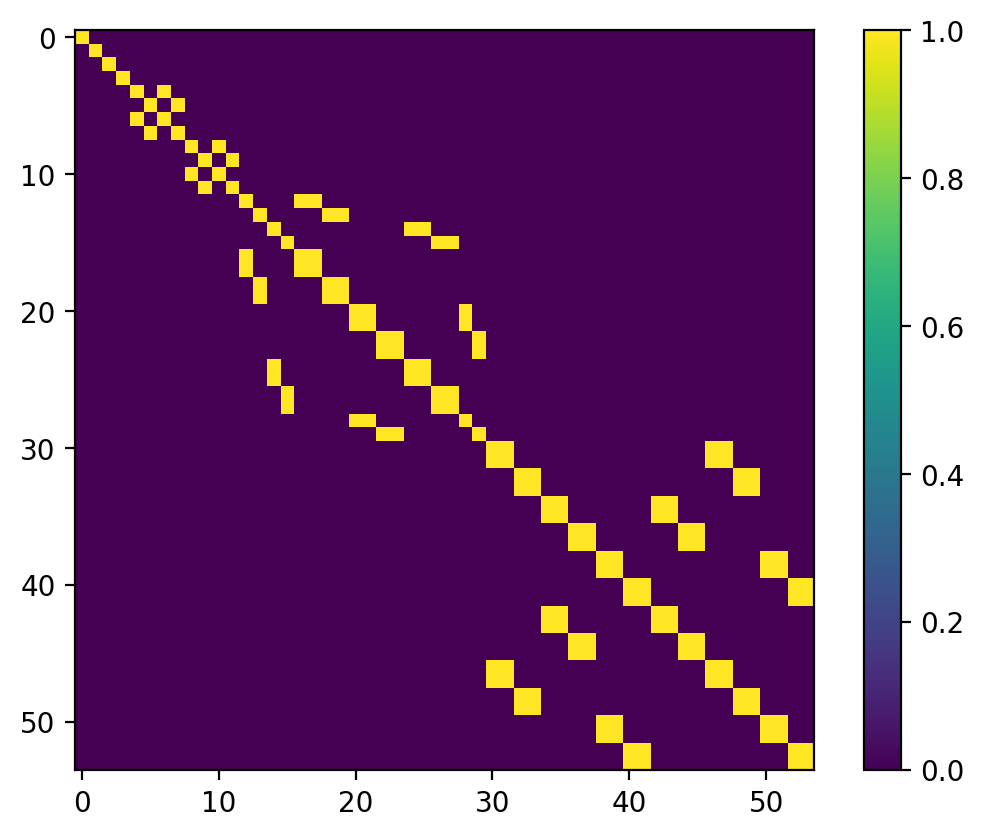

In [10]:
# There are redundant qets in that they only differ by a common phase.
rows = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    row = []
    for total_ket_key_1, simple_ket_1 in simplified_kets.items():
        the_sum = det_simplify((simple_ket_0 + simple_ket_1).dict)
        the_diff = det_simplify((simple_ket_0 - simple_ket_1).dict)
        if len(the_sum) == 0 or len(the_diff) == 0:
            row.append(1)
        else:
            row.append(0)
    rows.append(row)
plt.figure()
plt.imshow(np.array(rows))
plt.colorbar()
plt.show()

In [11]:
# This is alternative to qet division for figuring out
# which are proportional to each other
# supreme_qets = []
# corresponding_waves = []
# for total_ket_key_0, simple_ket_0 in simplified_kets.items():
#     plus_diffs = sum([len(det_simplify((simple_ket_0 + simple_ket_1).dict)) == 0 for simple_ket_1 in supreme_qets])
#     minus_diffs = sum([len(det_simplify((simple_ket_0 - simple_ket_1).dict)) == 0 for simple_ket_1 in supreme_qets])
#     if plus_diffs == 0 and minus_diffs == 0:
#         supreme_qets.append(simple_ket_0)
#         corresponding_waves.append(total_ket_key_0)

In [26]:
def qet_divide(qet0, qet1):
    '''
    Given   two   qets,   assumed   to   be   superpositions  of
    determinantal states. Determine if they are collinear and if
    they are, provide their ratio.

    Parameters
    ----------
    qet0    (qdef.Qet) : a qet with determinantal keys.
    qet1    (qdef.Qet) : a qet with determinantal keys.

    Returns
    -------
    ratio (num): 0 if qets are not collinear, otherwise equal to
    qet0/qet1.


    '''
    if len(qet0.dict) != len(qet1.dict):
        return 0
    set0 = frozenset(map(frozenset,qet0.dict.keys()))
    set1 = frozenset(map(frozenset,qet1.dict.keys()))
    num_parts = len(qet0.dict)
    # a necessary condition for them to be possibly collinear
    # is that they should have have the same sets of quantum
    # numbers.
    if set0 != set1:
        return 0
    else:
        ratios = []
        # iterate over the quantum nums of the first qet
        for qet_key_0, qet_val_0 in qet0.dict.items():
            set0 = set(qet_key_0)
            # and determine the ratio that it has
            # to all of the parts of the other qet
            # allowing for reaarangmenets valid
            # under determinantal state rules
            for qet_key_1, qet_val_1 in qet1.dict.items():
                set1 = set(qet_key_1)
                if set0 == set1:
                    ordering = [qet_key_0.index(qk) for qk in qet_key_1]
                    sign = εijk(*ordering)
                    ratios.append(sign * qet_val_0/qet_val_1)
                    continue
    if ratios == []:
        return 0
    else:
        # if all of the ratios are equal
        # then the ratio of the two qets
        # is well defined
        if len(set(ratios)) == 1 and len(ratios) == num_parts:
            return ratios[0]
        else:
            return 0

final_qets = []
corresponding_waves = []
for total_ket_key_0, simple_ket_0 in simplified_kets.items():
    ratios = []
    for simple_ket_1 in final_qets:
        divvy = qet_divide(simple_ket_0, simple_ket_1)
        ratios.append(divvy==0)
    ratios = sum(ratios)
    if ratios == len(final_qets):
        final_qets.append(simple_ket_0)
        corresponding_waves.append(total_ket_key_0)
final_qets = list(zip(corresponding_waves, final_qets))

In [27]:
import cmasher as cmr

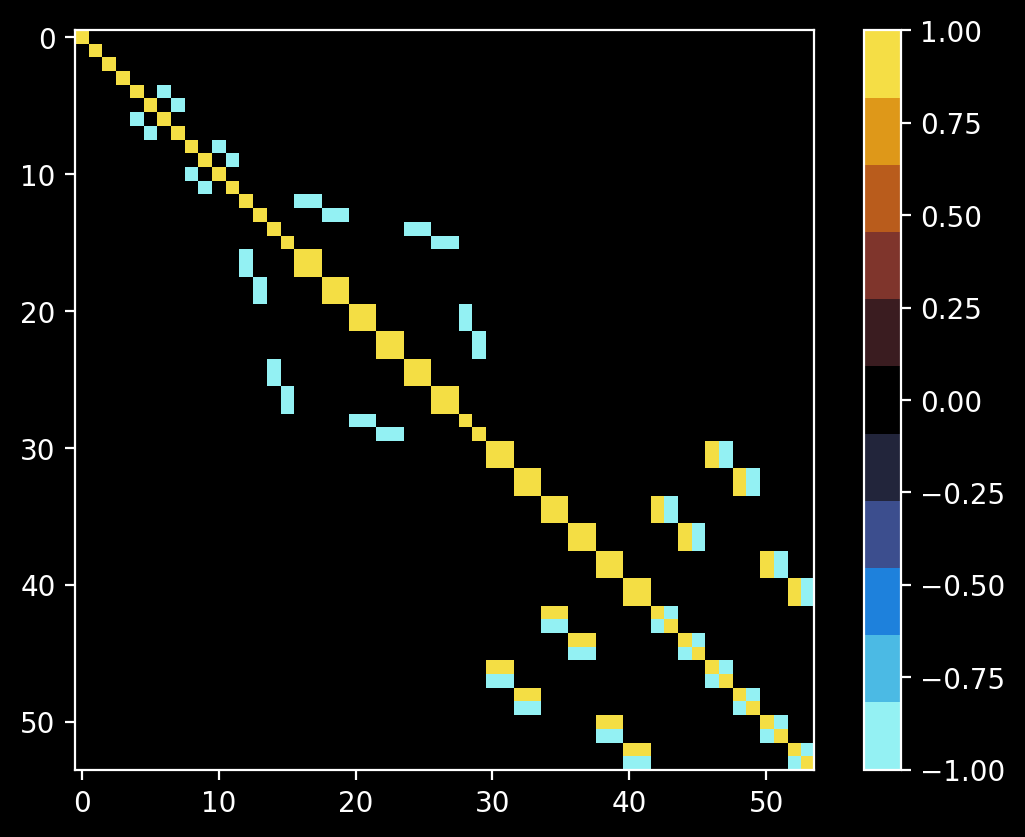

In [28]:
ratios = sp.Matrix([[qet_divide(q1, s0) for s0 in simplified_kets.values()] for q1 in simplified_kets.values()])
plt.style.use('dark_background')
plt.figure()
plt.imshow(np.array(ratios).astype(np.float64), cmap=cmr.get_sub_cmap('cmr.iceburn',0.,1,N=11))
plt.colorbar()
plt.show()

In [29]:
# in addition to removing the redundant ones
# I would also like to keep al the total_ket_keys that correspond to each
# group of redundant qets
final_qets_groups = {}
for main_key, sqet in final_qets:
    final_qets_groups[main_key] = {'paths':[],'qet':sqet}
    for total_ket_key_0, simple_ket_0 in simplified_kets.items():
        if qet_divide(sqet, simple_ket_0) != 0:
            final_qets_groups[main_key]['paths'].append(total_ket_key_0)
for k,v in final_qets_groups.items():
    print(k,'||', len(v['paths']), '||', (v['paths']))
    display(as_det_ket(v['qet']))

(A_2, {\beta}, 4, -3/2, 1, T_1) || 1 || [(A_2, {\beta}, 4, -3/2, 1, T_1)]


-|\bar{{\xi}} \bar{{\phi}} \bar{{\chi}}|

(A_2, {\beta}, 4, -1/2, 1, T_1) || 1 || [(A_2, {\beta}, 4, -1/2, 1, T_1)]


-sqrt(3)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/3 - sqrt(3)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/3 - sqrt(3)*|{\xi} \bar{{\phi}} \bar{{\chi}}|/3

(A_2, {\beta}, 4, 1/2, 1, T_1) || 1 || [(A_2, {\beta}, 4, 1/2, 1, T_1)]


-sqrt(3)*|\bar{{\xi}} {\phi} {\chi}|/3 - sqrt(3)*|{\xi} \bar{{\phi}} {\chi}|/3 - sqrt(3)*|{\xi} {\phi} \bar{{\chi}}|/3

(A_2, {\beta}, 4, 3/2, 1, T_1) || 1 || [(A_2, {\beta}, 4, 3/2, 1, T_1)]


-|{\xi} {\phi} {\chi}|

(E, {\gamma}, 2, -1/2, 1, T_1) || 2 || [(E, {\gamma}, 2, -1/2, 1, T_1), (E, {\gamma}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/2 + sqrt(2)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/2

(E, {\zeta}, 2, -1/2, 1, T_1) || 2 || [(E, {\zeta}, 2, -1/2, 1, T_1), (E, {\zeta}, 2, -1/2, 0, T_2)]


sqrt(6)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/6 + sqrt(6)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/6 - sqrt(6)*|{\xi} \bar{{\phi}} \bar{{\chi}}|/3

(E, {\gamma}, 2, 1/2, 1, T_1) || 2 || [(E, {\gamma}, 2, 1/2, 1, T_1), (E, {\gamma}, 2, 1/2, 0, T_2)]


-sqrt(2)*|{\xi} \bar{{\phi}} {\chi}|/2 + sqrt(2)*|{\xi} {\phi} \bar{{\chi}}|/2

(E, {\zeta}, 2, 1/2, 1, T_1) || 2 || [(E, {\zeta}, 2, 1/2, 1, T_1), (E, {\zeta}, 2, 1/2, 0, T_2)]


sqrt(6)*|\bar{{\xi}} {\phi} {\chi}|/3 - sqrt(6)*|{\xi} \bar{{\phi}} {\chi}|/6 - sqrt(6)*|{\xi} {\phi} \bar{{\chi}}|/6

(T_1, {\nu}, 2, -1/2, 0, E) || 3 || [(T_1, {\nu}, 2, -1/2, 0, E), (T_1, {\nu}, 2, -1/2, 1, T_1), (T_1, {\nu}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\phi}}|/2 + sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\phi}}|/2

(T_1, {\nu}, 2, 1/2, 0, E) || 3 || [(T_1, {\nu}, 2, 1/2, 0, E), (T_1, {\nu}, 2, 1/2, 1, T_1), (T_1, {\nu}, 2, 1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} {\phi}|/2 + sqrt(2)*|\bar{{\xi}} {\xi} {\phi}|/2

(T_1, {\eta}, 2, -1/2, 0, E) || 3 || [(T_1, {\eta}, 2, -1/2, 0, E), (T_1, {\eta}, 2, -1/2, 1, T_1), (T_1, {\eta}, 2, -1/2, 0, T_2)]


sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\chi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\chi}}|/2

(T_1, {\eta}, 2, 1/2, 0, E) || 3 || [(T_1, {\eta}, 2, 1/2, 0, E), (T_1, {\eta}, 2, 1/2, 1, T_1), (T_1, {\eta}, 2, 1/2, 0, T_2)]


sqrt(2)*|\bar{{\phi}} {\phi} {\chi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\chi}|/2

(T_1, {\mu}, 2, -1/2, 1, T_1) || 3 || [(T_1, {\mu}, 2, -1/2, 1, T_1), (T_1, {\mu}, 2, -1/2, 0, T_2), (T_1, {\mu}, 2, -1/2, 0, E)]


-sqrt(2)*|\bar{{\xi}} \bar{{\chi}} {\chi}|/2 + sqrt(2)*|\bar{{\xi}} \bar{{\phi}} {\phi}|/2

(T_1, {\mu}, 2, 1/2, 1, T_1) || 3 || [(T_1, {\mu}, 2, 1/2, 1, T_1), (T_1, {\mu}, 2, 1/2, 0, T_2), (T_1, {\mu}, 2, 1/2, 0, E)]


-sqrt(2)*|{\xi} \bar{{\chi}} {\chi}|/2 + sqrt(2)*|{\xi} \bar{{\phi}} {\phi}|/2

(T_2, {\xi}, 2, -1/2, 0, A_1) || 4 || [(T_2, {\xi}, 2, -1/2, 0, A_1), (T_2, {\xi}, 2, -1/2, 0, E), (T_2, {\xi}, 2, -1/2, 1, T_1), (T_2, {\xi}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\xi}}|/2 - sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\xi}}|/2

(T_2, {\xi}, 2, 1/2, 0, A_1) || 4 || [(T_2, {\xi}, 2, 1/2, 0, A_1), (T_2, {\xi}, 2, 1/2, 0, E), (T_2, {\xi}, 2, 1/2, 1, T_1), (T_2, {\xi}, 2, 1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} {\xi}|/2 - sqrt(2)*|\bar{{\phi}} {\phi} {\xi}|/2

(T_2, {\phi}, 2, -1/2, 0, A_1) || 4 || [(T_2, {\phi}, 2, -1/2, 0, A_1), (T_2, {\phi}, 2, -1/2, 0, E), (T_2, {\phi}, 2, -1/2, 1, T_1), (T_2, {\phi}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\phi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\phi}}|/2

(T_2, {\phi}, 2, 1/2, 0, A_1) || 4 || [(T_2, {\phi}, 2, 1/2, 0, A_1), (T_2, {\phi}, 2, 1/2, 0, E), (T_2, {\phi}, 2, 1/2, 1, T_1), (T_2, {\phi}, 2, 1/2, 0, T_2)]


-sqrt(2)*|\bar{{\chi}} {\chi} {\phi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\phi}|/2

(T_2, {\chi}, 2, -1/2, 0, A_1) || 4 || [(T_2, {\chi}, 2, -1/2, 0, A_1), (T_2, {\chi}, 2, -1/2, 0, E), (T_2, {\chi}, 2, -1/2, 1, T_1), (T_2, {\chi}, 2, -1/2, 0, T_2)]


-sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\chi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\chi}}|/2

(T_2, {\chi}, 2, 1/2, 0, A_1) || 4 || [(T_2, {\chi}, 2, 1/2, 0, A_1), (T_2, {\chi}, 2, 1/2, 0, E), (T_2, {\chi}, 2, 1/2, 1, T_1), (T_2, {\chi}, 2, 1/2, 0, T_2)]


-sqrt(2)*|\bar{{\phi}} {\phi} {\chi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\chi}|/2

In [55]:
display(Math('$%s$' % sp.latex(as_det_ket(sq))))

<IPython.core.display.Math object>

In [47]:
for idx, sq in enumerate(supreme_qets):
    total_ket_key = (corresponding_waves[idx])
    e_config = sp.Symbol(sp.latex(Γ1).lower())*sp.Symbol(sp.latex(Γ2).lower())*sp.Symbol(sp.latex(Γ3).lower())
    final_term_symbol = sp.Symbol('{}^{%d}%s' % (total_ket_key[2],sp.latex(total_ket_key[0])))
    intermediate_term_symbol = sp.Symbol('{}^{%d}%s' % (int(total_ket_key[-2]*2+1),sp.latex(total_ket_key[-1])))
    three_qet_symb = sp.Matrix([e_config, sp.Symbol('(%s)' % sp.latex(intermediate_term_symbol)),final_term_symbol, total_ket_key[3], total_ket_key[1]]).T
    display(three_qet_symb)
    display(as_det_ket(sq))

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{4}A_{2}, -3/2, {\beta}]])

-|\bar{{\xi}} \bar{{\phi}} \bar{{\chi}}|

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{4}A_{2}, -1/2, {\beta}]])

-sqrt(3)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/3 - sqrt(3)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/3 - sqrt(3)*|{\xi} \bar{{\phi}} \bar{{\chi}}|/3

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{4}A_{2}, 1/2, {\beta}]])

-sqrt(3)*|\bar{{\xi}} {\phi} {\chi}|/3 - sqrt(3)*|{\xi} \bar{{\phi}} {\chi}|/3 - sqrt(3)*|{\xi} {\phi} \bar{{\chi}}|/3

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{4}A_{2}, 3/2, {\beta}]])

-|{\xi} {\phi} {\chi}|

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}E, -1/2, {\gamma}]])

-sqrt(2)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/2 + sqrt(2)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/2

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}E, -1/2, {\zeta}]])

sqrt(6)*|\bar{{\xi}} \bar{{\phi}} {\chi}|/6 + sqrt(6)*|\bar{{\xi}} {\phi} \bar{{\chi}}|/6 - sqrt(6)*|{\xi} \bar{{\phi}} \bar{{\chi}}|/3

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}E, 1/2, {\gamma}]])

-sqrt(2)*|{\xi} \bar{{\phi}} {\chi}|/2 + sqrt(2)*|{\xi} {\phi} \bar{{\chi}}|/2

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}E, 1/2, {\zeta}]])

sqrt(6)*|\bar{{\xi}} {\phi} {\chi}|/3 - sqrt(6)*|{\xi} \bar{{\phi}} {\chi}|/6 - sqrt(6)*|{\xi} {\phi} \bar{{\chi}}|/6

Matrix([[t_{2}**3, ({}^{1}E), {}^{2}T_{1}, -1/2, {\nu}]])

-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\phi}}|/2 + sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\phi}}|/2

Matrix([[t_{2}**3, ({}^{1}E), {}^{2}T_{1}, 1/2, {\nu}]])

-sqrt(2)*|\bar{{\chi}} {\chi} {\phi}|/2 + sqrt(2)*|\bar{{\xi}} {\xi} {\phi}|/2

Matrix([[t_{2}**3, ({}^{1}E), {}^{2}T_{1}, -1/2, {\eta}]])

sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\chi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\chi}}|/2

Matrix([[t_{2}**3, ({}^{1}E), {}^{2}T_{1}, 1/2, {\eta}]])

sqrt(2)*|\bar{{\phi}} {\phi} {\chi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\chi}|/2

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}T_{1}, -1/2, {\mu}]])

-sqrt(2)*|\bar{{\xi}} \bar{{\chi}} {\chi}|/2 + sqrt(2)*|\bar{{\xi}} \bar{{\phi}} {\phi}|/2

Matrix([[t_{2}**3, ({}^{3}T_{1}), {}^{2}T_{1}, 1/2, {\mu}]])

-sqrt(2)*|{\xi} \bar{{\chi}} {\chi}|/2 + sqrt(2)*|{\xi} \bar{{\phi}} {\phi}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, -1/2, {\xi}]])

-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\xi}}|/2 - sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\xi}}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, 1/2, {\xi}]])

-sqrt(2)*|\bar{{\chi}} {\chi} {\xi}|/2 - sqrt(2)*|\bar{{\phi}} {\phi} {\xi}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, -1/2, {\phi}]])

-sqrt(2)*|\bar{{\chi}} {\chi} \bar{{\phi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\phi}}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, 1/2, {\phi}]])

-sqrt(2)*|\bar{{\chi}} {\chi} {\phi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\phi}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, -1/2, {\chi}]])

-sqrt(2)*|\bar{{\phi}} {\phi} \bar{{\chi}}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} \bar{{\chi}}|/2

Matrix([[t_{2}**3, ({}^{1}A_{1}), {}^{2}T_{2}, 1/2, {\chi}]])

-sqrt(2)*|\bar{{\phi}} {\phi} {\chi}|/2 - sqrt(2)*|\bar{{\xi}} {\xi} {\chi}|/2

In [130]:
# bar symbols according to their spin
def slater_det(single_electron_state):
    spinors = []
    for ses in single_electron_state:
        if ses[0] < 0:
            spinor = sp.Symbol(r'\bar{%s}' % sp.latex(ses[1]))
        else:
            spinor = ses[1]
        spinors.append(spinor)
    # qet_dict = [((spinor[0],spinor[1],spinor[2]),1),
    #             (spinor[])]
    apply_permutation = lambda σ, iter : (iter[σ[0]], iter[σ[1]], iter[σ[2]])
    # find the permutations
    σs = list(permutations(range(len(spinors)), len(spinors)))
    # apply with their corresponding sign
    slater  = ([(apply_permutation(σ, spinors), εijk(*σ)) for σ in σs])
    qet = Qet()
    for slate in slater:
        qet += Qet({slate[0]:slate[1]})
    return qet

Qet({(\bar{{\xi}}, {\chi}, {\xi}): -sqrt(2)/2, (\bar{{\phi}}, {\chi}, {\phi}): -sqrt(2)/2})

In [ ]:
total_kets_symmetrized = {}
for total_ket_key, ket_parts in simplified_kets.items():
    slater_parts = [slater_det(k)*v for k,v in ket_parts.dict.items()]
    total_sym = sum(slater_parts, Qet({}))
    if len(total_sym.dict) > 0:
        total_kets_symmetrized[total_ket_key] = total_sym